# **AI IN BIOMEDICINE - FINAL ASSIGNMENT**

> **Authors of the notebook:** Pedro Gianjoppe, Alix de Langlais, Felipe Pascutti, Gianmarco Tardini

> **Goal:** In this homework, the objectif is to classify X-Ray images, which are divided into three categories: images of normal patients, images of tuberculosis patients, images of patients with pneumonia. The objective is also to perform XAI analysis to make the AI explainable. 

----


# **1. Introduction**

## 1.1 Set up the environment

In [ ]:
# Import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import logging
import shutil
import matplotlib.cm as cm
import sklearn
from numpy import expand_dims
from IPython.display import Image, display
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
import matplotlib.cm as c_map
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from os import listdir
import matplotlib.image as mpimg
from matplotlib import rcParams

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# Suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## 1.2 Mount the *My Drive* folder

In [ ]:
#Link colab to the directories of a given google drive account
import os
from google.colab import drive
ROOT_PATH = os.path.join('/content/drive')
drive.mount(ROOT_PATH)

Mounted at /content/drive


In [ ]:
date_version = '140123'
%cd /content/drive/Shareddrives/Applied AI Project/Pedro
%ls

/content/drive/Shareddrives/Applied AI Project/Pedro
 AIProject_CNN+MLClassifier_040123.ipynb
 AIProject_CNN+MLClassifier_050123.ipynb
 AIProject_CNN+MLClassifier_050123_v1.ipynb
 AIProject_CNN+MLClassifier_050123_v2.ipynb
 AIProject_CNN+MLClassifier_060123_v0.ipynb
 AIProject_CNN+MLClassifier_090123.ipynb
 AIProject_CNN+MLClassifier_100123.ipynb
 AIProject_CNN+MLClassifier_100123_v0.ipynb
 AIProject_CNN+MLClassifier_110123.ipynb
 AIProject_CNN+MLClassifier_120123.ipynb
 AIProject_CNN+MLClassifier_140123.ipynb
 AIProject_TransferLearning_020123_v0.ipynb
 AIProject_TransferLearning_020123_v1.ipynb
 AIProject_TransferLearning_030123_v0.ipynb
 AIProject_TransferLearning_030123_v1.ipynb
 AIProject_TransferLearning_040123_v1.ipynb
 AIProject_TransferLearning_testEfficientNet_all_data_030123.ipynb
 code_test_071222.ipynb
 Dataset/
 Dataset_30/
 Dataset_300/
 final_dataset_dir/
 LogBook.gdoc
 model_DenseNet+AdaBoost_120123.pkl
 model_DenseNet+RF_110123.pkl
 model.png
 models_experiments/
 mod

## 1.3 Extract the files from the compressed archive

In [ ]:
'''import zipfile

with zipfile.ZipFile('/content/drive/Shareddrives/Applied AI Project/train_set_v2.zip','r') as zip_ref:
  zip_ref.extractall('/content/drive/Shareddrives/Applied AI Project/Alix/train - no noise')'''

"import zipfile\n\nwith zipfile.ZipFile('/content/drive/Shareddrives/Applied AI Project/train_set_v2.zip','r') as zip_ref:\n  zip_ref.extractall('/content/drive/Shareddrives/Applied AI Project/Alix/train - no noise')"

# **2. Data Loading**

Already done by the running the file AIProject_CNN.ipynb

# **3. Data Augmentation**

Already done by the running the file AIProject_CNN.ipynb

# **4. Data Loader - Image Data Generator**

In [ ]:
# Dataset folders 
dataset_dir = '/content/drive/Shareddrives/Applied AI Project/Alix/Dataset_130123'
training_dir = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')
augmentation_dir = os.path.join(dataset_dir, 'augmentation')

In [ ]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.

labels = ['Normal',   
          'Pneumonia',   
          'Tuberculosis']
          
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()
test_data_gen = ImageDataGenerator()

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=augmentation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)

valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

test_gen = train_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(256,256),
                                              color_mode='rgb',
                                              classes=labels, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

Found 7086 images belonging to 3 classes.
Found 360 images belonging to 3 classes.
Found 360 images belonging to 3 classes.


In [ ]:
print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Normal': 0, 'Pneumonia': 1, 'Tuberculosis': 2}

Target classes
[0 0 0 ... 2 2 2]


In [ ]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (8, 256, 256, 3)
Target shape: (8, 3)

Categorical label: [0. 1. 0.]
Label: 1
Class name: Pneumonia


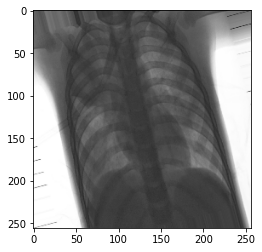

In [ ]:
# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

# **5. Transfer Learning**

In [ ]:
# Download and import visualkeras library
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 34.7 MB/s eta 0:00:00


In [ ]:
# Model metadata
input_shape = (256, 256, 3)


## **5.1. VGG16**

### a) Pre-processing VGG16

In [ ]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.

labels = ['Normal',   
          'Pneumonia',   
          'Tuberculosis']
          
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator(preprocessing_function=tfk.applications.vgg16.preprocess_input)
valid_data_gen = ImageDataGenerator(preprocessing_function=tfk.applications.vgg16.preprocess_input)
test_data_gen = ImageDataGenerator(preprocessing_function=tfk.applications.vgg16.preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=augmentation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)

valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

test_gen = train_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(256,256),
                                              color_mode='rgb',
                                              classes=labels, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

Found 438 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 26 images belonging to 3 classes.


### b) Build the model

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

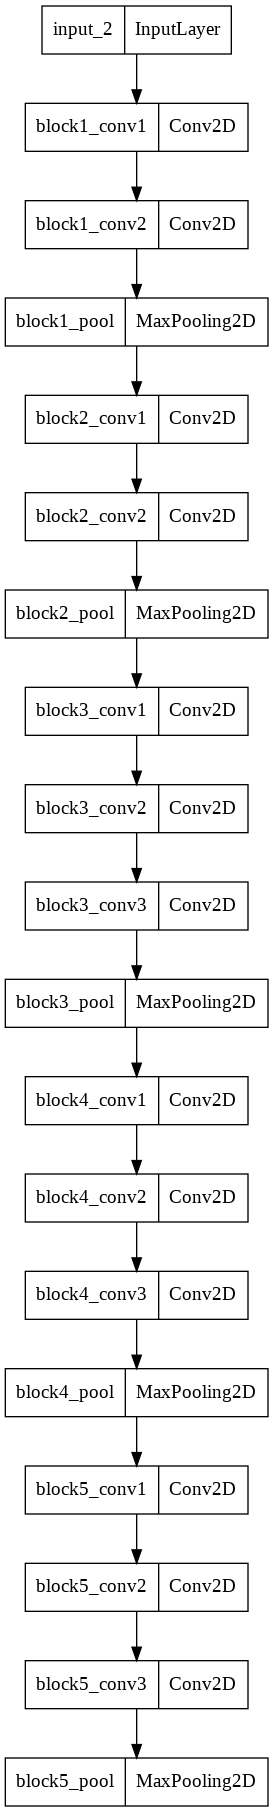

In [ ]:
# Download and plot the VGG16 model
vgg_model = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)
vgg_model.summary()
tfk.utils.plot_model(vgg_model)

In [ ]:
def build_model(input_shape):

    ##INPUT

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    ##VGG16 as feature extractor
    x = vgg_model(input_layer)

    #x = tfkl.Flatten(name='Flattening')(x)

    x = tfkl.Dropout(0.4, seed=seed)(x)

    """
    ##MLP
    #The first hidden layer consists of 128 nodes, while the second hidden layer consists of 64 nodes. 
    # Both hidden layers use 40% dropout rate and rectified linear unit (ReLU) activation function

    x = tfkl.Dense(
        128, 
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed))(x)

    x = tfkl.Dropout(0.4, seed=seed)(x)

    x = tfkl.Dense(
        64, 
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed))(x)"""

    ## Global pooling
    x = tfkl.BatchNormalization()(x)

    x = tfkl.GlobalAveragePooling2D()(x)

    x = tfkl.Dropout(0.4, seed=seed)(x)
    
    output_layer = tfkl.Dense(units=3, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(x)


    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    ##Fine-tuning
    #the first 3 convolutional blocks in VGG16 is preserved from previously learned while the fourth and fifth convolutional block is 
    #trained based on our flower image dataset
    for i, layer in enumerate(model.get_layer('vgg16').layers[:11]):
      layer.trainable=False
    for i, layer in enumerate(model.get_layer('vgg16').layers):
      print(i, layer.name, layer.trainable)

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 dropout_2 (Dropout)         (None, 8, 8, 512)         0         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 512)        2048      
 

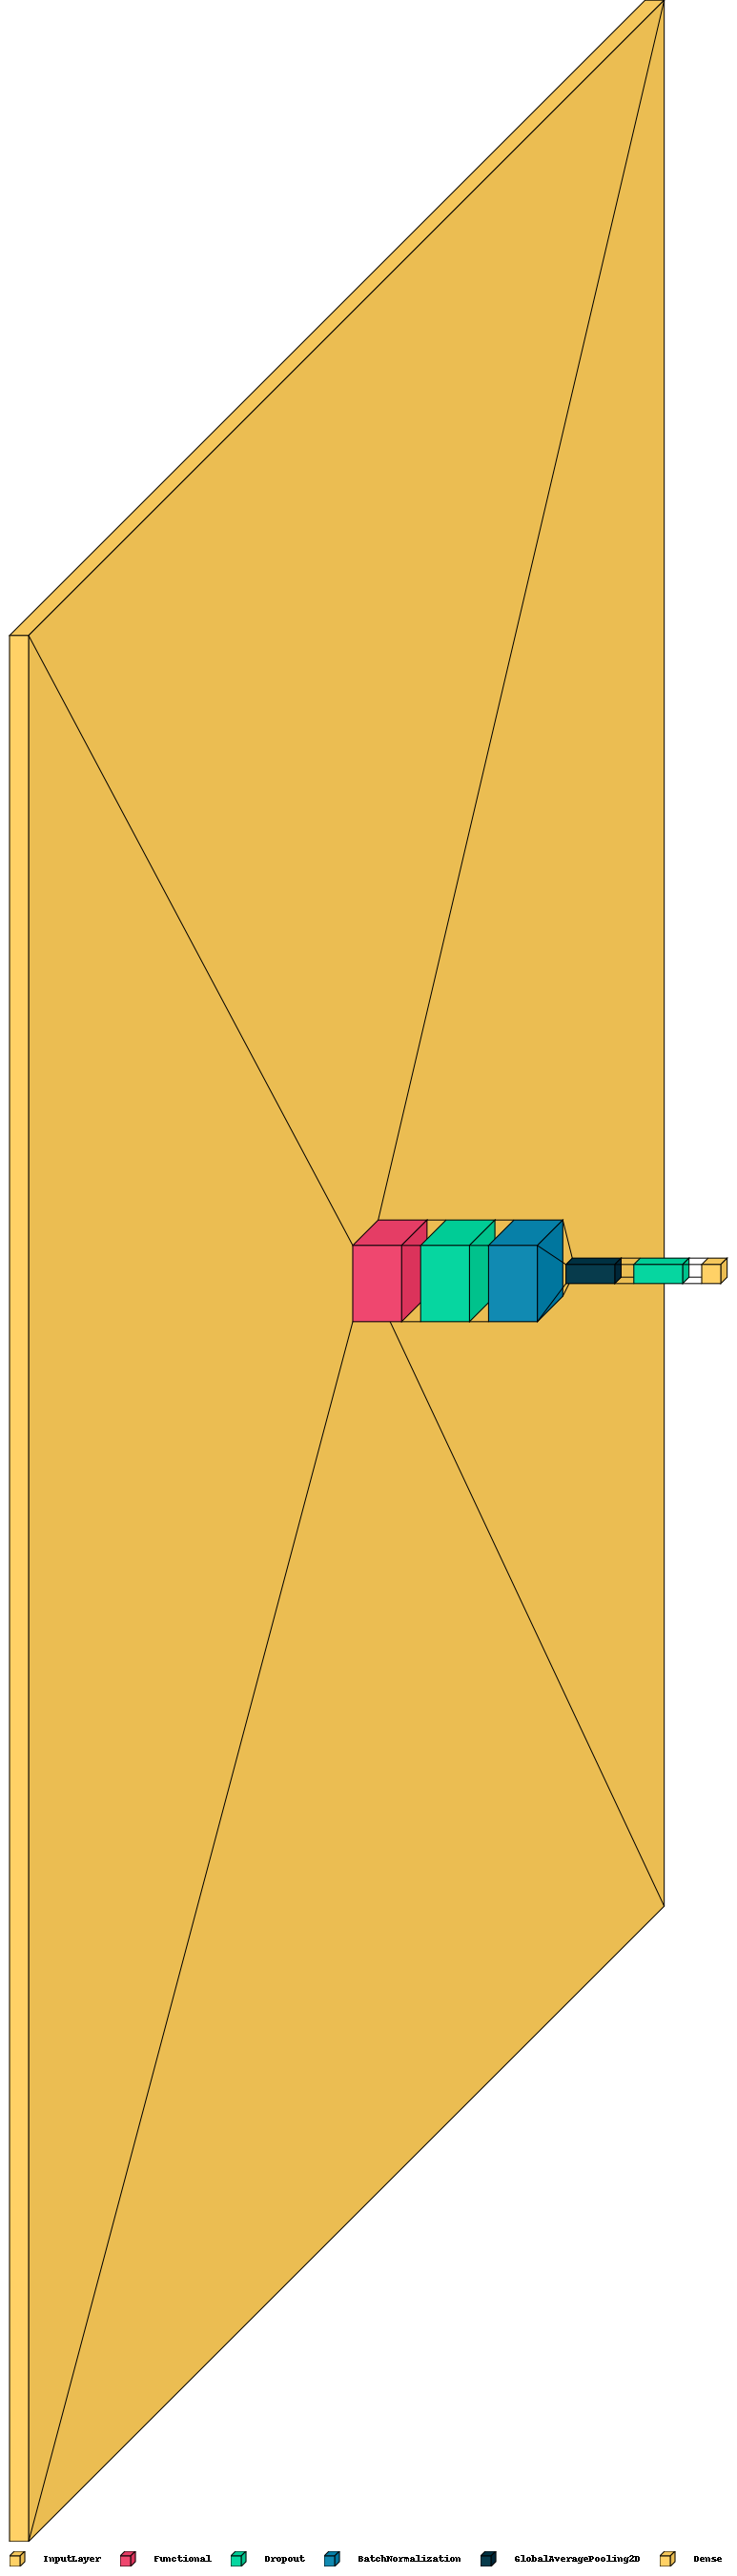

In [ ]:
model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

### c) Train and save the model

In [ ]:
# Create folders and callbacks and fit
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = 'auto', patience=15, restore_best_weights = True)

# Train the model
history = model.fit(
    x = train_gen,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = callbacks,
).history

Epoch 1/200
55/55 [==============================] - 191s 3s/step - loss: 0.7785 - accuracy: 0.6735 - val_loss: 1.7270 - val_accuracy: 0.6333
Epoch 2/200
55/55 [==============================] - 11s 205ms/step - loss: 0.5818 - accuracy: 0.7785 - val_loss: 2.8779 - val_accuracy: 0.4000
Epoch 3/200
55/55 [==============================] - 10s 173ms/step - loss: 0.4795 - accuracy: 0.8196 - val_loss: 1.7672 - val_accuracy: 0.5000
Epoch 4/200
55/55 [==============================] - 10s 187ms/step - loss: 0.3464 - accuracy: 0.8790 - val_loss: 0.4447 - val_accuracy: 0.7667
Epoch 5/200
55/55 [==============================] - 15s 271ms/step - loss: 0.3545 - accuracy: 0.8721 - val_loss: 0.4318 - val_accuracy: 0.8333
Epoch 6/200
55/55 [==============================] - 12s 210ms/step - loss: 0.2989 - accuracy: 0.8927 - val_loss: 0.7050 - val_accuracy: 0.8333
Epoch 7/200
55/55 [==============================] - 10s 179ms/step - loss: 0.2264 - accuracy: 0.9269 - val_loss: 0.6681 - val_accuracy: 0

In [ ]:
# Save best epoch model
str_directory_VGG16 = os.path.join('models_experiments','Experiments_' + date_version + '/VGG16_' + date_version)
model.save(str_directory_VGG16)

### d) Plot

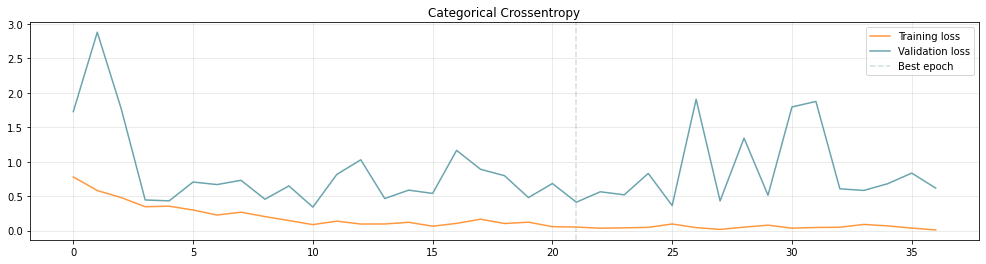

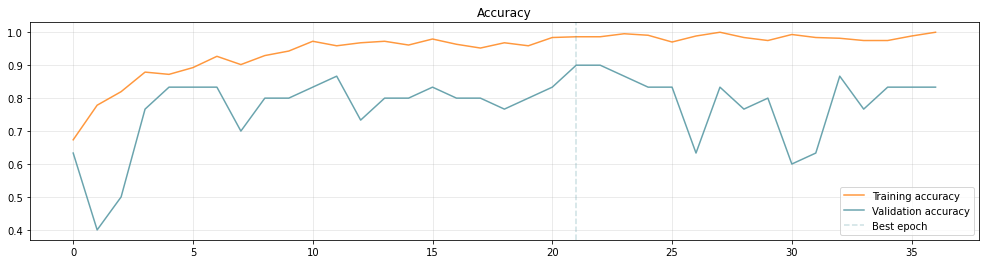

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()


### e) Predictions and confusion matrix

In [ ]:
data =  {
'acc_train': [],
'acc_test': [],
'loss_test': [],
'Accuracy' : [],
'Precision' : [],
'Recall' : [],
'Global F1' : [],
'F1 Normal' : [],
'F1 Pneumonia' : [],
'F1 Tuberculosis' : [],
}

df_results = pd.DataFrame(data)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

results = model.evaluate(test_gen, return_dict=True)

frame_history = pd.DataFrame.from_dict(history)
acc_train = frame_history[['accuracy']].iloc[-1].values

frame_results = pd.DataFrame(data=results, index = model.metrics_names).transpose()
acc_test = frame_results[['accuracy']].values[1]
loss_test = frame_results[['accuracy']].values[0]


# Predict the values from the test set
Y_pred = model.predict_generator(test_gen)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true = test_gen.classes,y_pred = Y_pred_classes)

# Compute the classification metrics
accuracy = accuracy_score(y_true = test_gen.classes,y_pred = Y_pred_classes)
precision = precision_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average='macro')
recall = recall_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average='macro')
f1 = f1_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average='macro')
f1_vector = f1_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average=None)


# Dictionnary with metrics

print('acc_train: ', acc_train)
print('acc_test: ', acc_test)
print('loss_test: ', loss_test)
print('Accuracy', accuracy.round(4))
print('Precision', precision.round(4))
print('Recall', recall.round(4))
print('Global F1', f1.round(4))
print('F1 Normal', f1_vector[0])
print('F1 Pneumonia', f1_vector[1])
print('F1 Tuberculosis', f1_vector[2])


new_row =  {
'acc_train': acc_train,
'acc_test': acc_test,
'loss_test': loss_test,
'Accuracy' : accuracy.round(4),
'Precision' : precision.round(4),
'Recall' : recall.round(4),
'Global F1' : f1.round(4),
'F1 Normal' : f1_vector[0],
'F1 Pneumonia' : f1_vector[1],
'F1 Tuberculosis' : f1_vector[2],
}

df_results = df_results.append(new_row, ignore_index=True)

df_results.to_excel('results_VGG16.xlsx')
!cp results_VGG16.xlsx "/content/drive/Shareddrives/Applied AI Project/Pedro/Results" #wherever u want

df_results

4/4 [==============================] - 15s 5s/step - loss: 0.2759 - accuracy: 0.8462
acc_train:  [1.]
acc_test:  [0.84615386]
loss_test:  [0.27592367]
Accuracy 0.9
Precision 0.8972
Recall 0.8926
Global F1 0.8934
F1 Normal 0.823529411764706
F1 Pneumonia 0.9565217391304348
F1 Tuberculosis 0.9


acc_train              acc_test             loss_test  Accuracy  Precision  \
0     [1.0]  [0.8461538553237915]  [0.2759236693382263]       0.9     0.8972   

   Recall  Global F1  F1 Normal  F1 Pneumonia  F1 Tuberculosis  
0  0.8926     0.8934   0.823529      0.956522              0.9

## **5.2. InceptionV3**

### a) Pre-processing InceptionV3

In [ ]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.

labels = ['Normal',   
          'Pneumonia',   
          'Tuberculosis']
          
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator(preprocessing_function=tfk.applications.inception_v3.preprocess_input)
valid_data_gen = ImageDataGenerator(preprocessing_function=tfk.applications.inception_v3.preprocess_input)
test_data_gen = ImageDataGenerator(preprocessing_function=tfk.applications.inception_v3.preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=augmentation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)

valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

test_gen = train_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(256,256),
                                              color_mode='rgb',
                                              classes=labels, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

Found 438 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 26 images belonging to 3 classes.


### b) Build the model

87910968/87910968 [==============================] - 5s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 rmalization)         

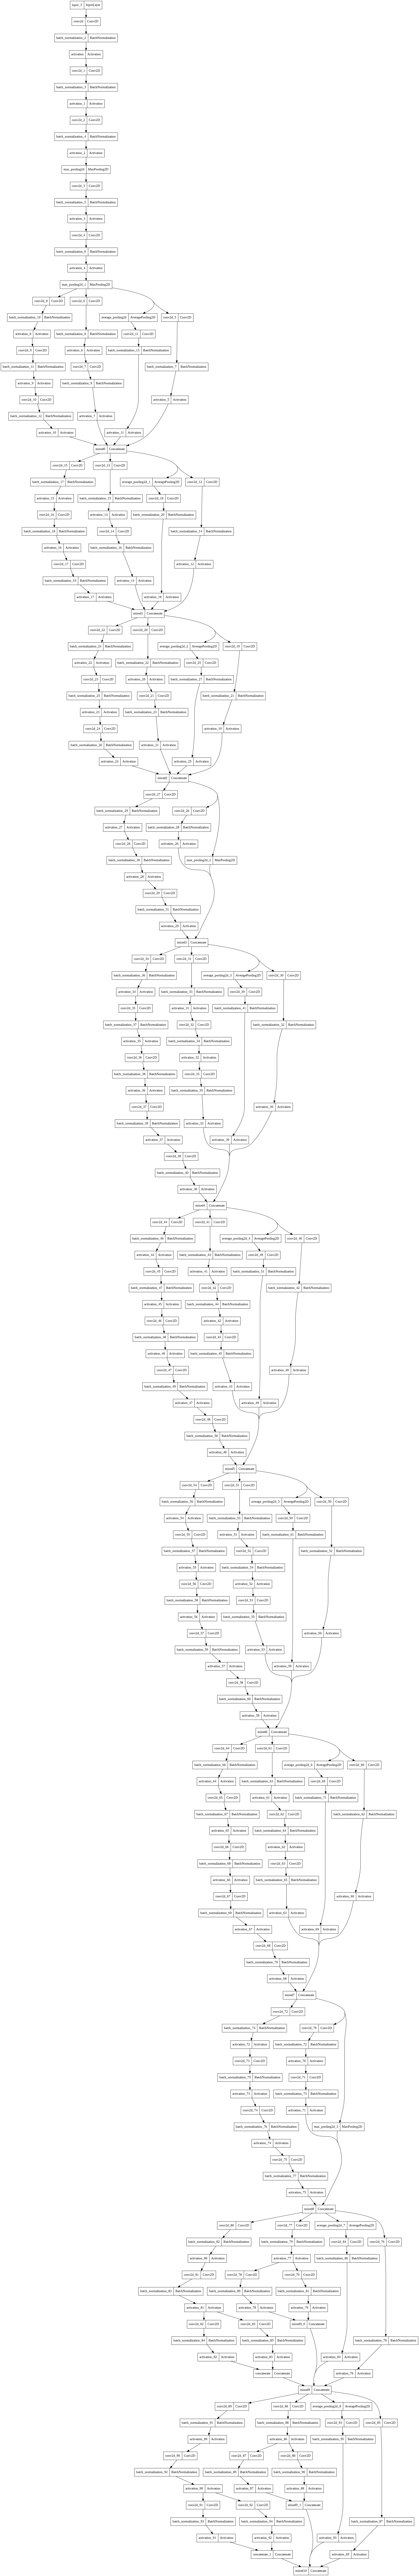

In [ ]:
# Download and plot the VGG16 model
inception_v3 = tfk.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)
inception_v3.summary()
tfk.utils.plot_model(inception_v3)

In [ ]:
def build_model(input_shape):

    ##INPUT

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    ##INCEPTIONV3 as feature extractor
    x = inception_v3(input_layer)

    #x = tfkl.Flatten(name='Flattening')(x)

    x = tfkl.Dropout(0.4, seed=seed)(x)

    """
    ##MLP
    #The first hidden layer consists of 128 nodes, while the second hidden layer consists of 64 nodes. 
    # Both hidden layers use 40% dropout rate and rectified linear unit (ReLU) activation function

    x = tfkl.Dense(
        128, 
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed))(x)

    x = tfkl.Dropout(0.4, seed=seed)(x)

    x = tfkl.Dense(
        64, 
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed))(x)"""

    ## Global pooling
    x = tfkl.BatchNormalization()(x)

    x = tfkl.GlobalAveragePooling2D()(x)

    x = tfkl.Dropout(0.4, seed=seed)(x)
    
    output_layer = tfkl.Dense(units=3, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(x)


    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    ##Fine-tuning
    #frozen before mixed7 layer
    for i, layer in enumerate(model.get_layer('inception_v3').layers[:228 ]):
      layer.trainable=False
    for i, layer in enumerate(model.get_layer('inception_v3').layers):
      print(i, layer.name, layer.trainable)

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model

0 input_3 False
1 conv2d False
2 batch_normalization_2 False
3 activation False
4 conv2d_1 False
5 batch_normalization_3 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_4 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_5 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_6 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_10 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_8 False
24 batch_normalization_11 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_7 False
33 batch_normalization_9 False
34 batch_normalization_12 False
35 batch_normalization_13 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_17 F

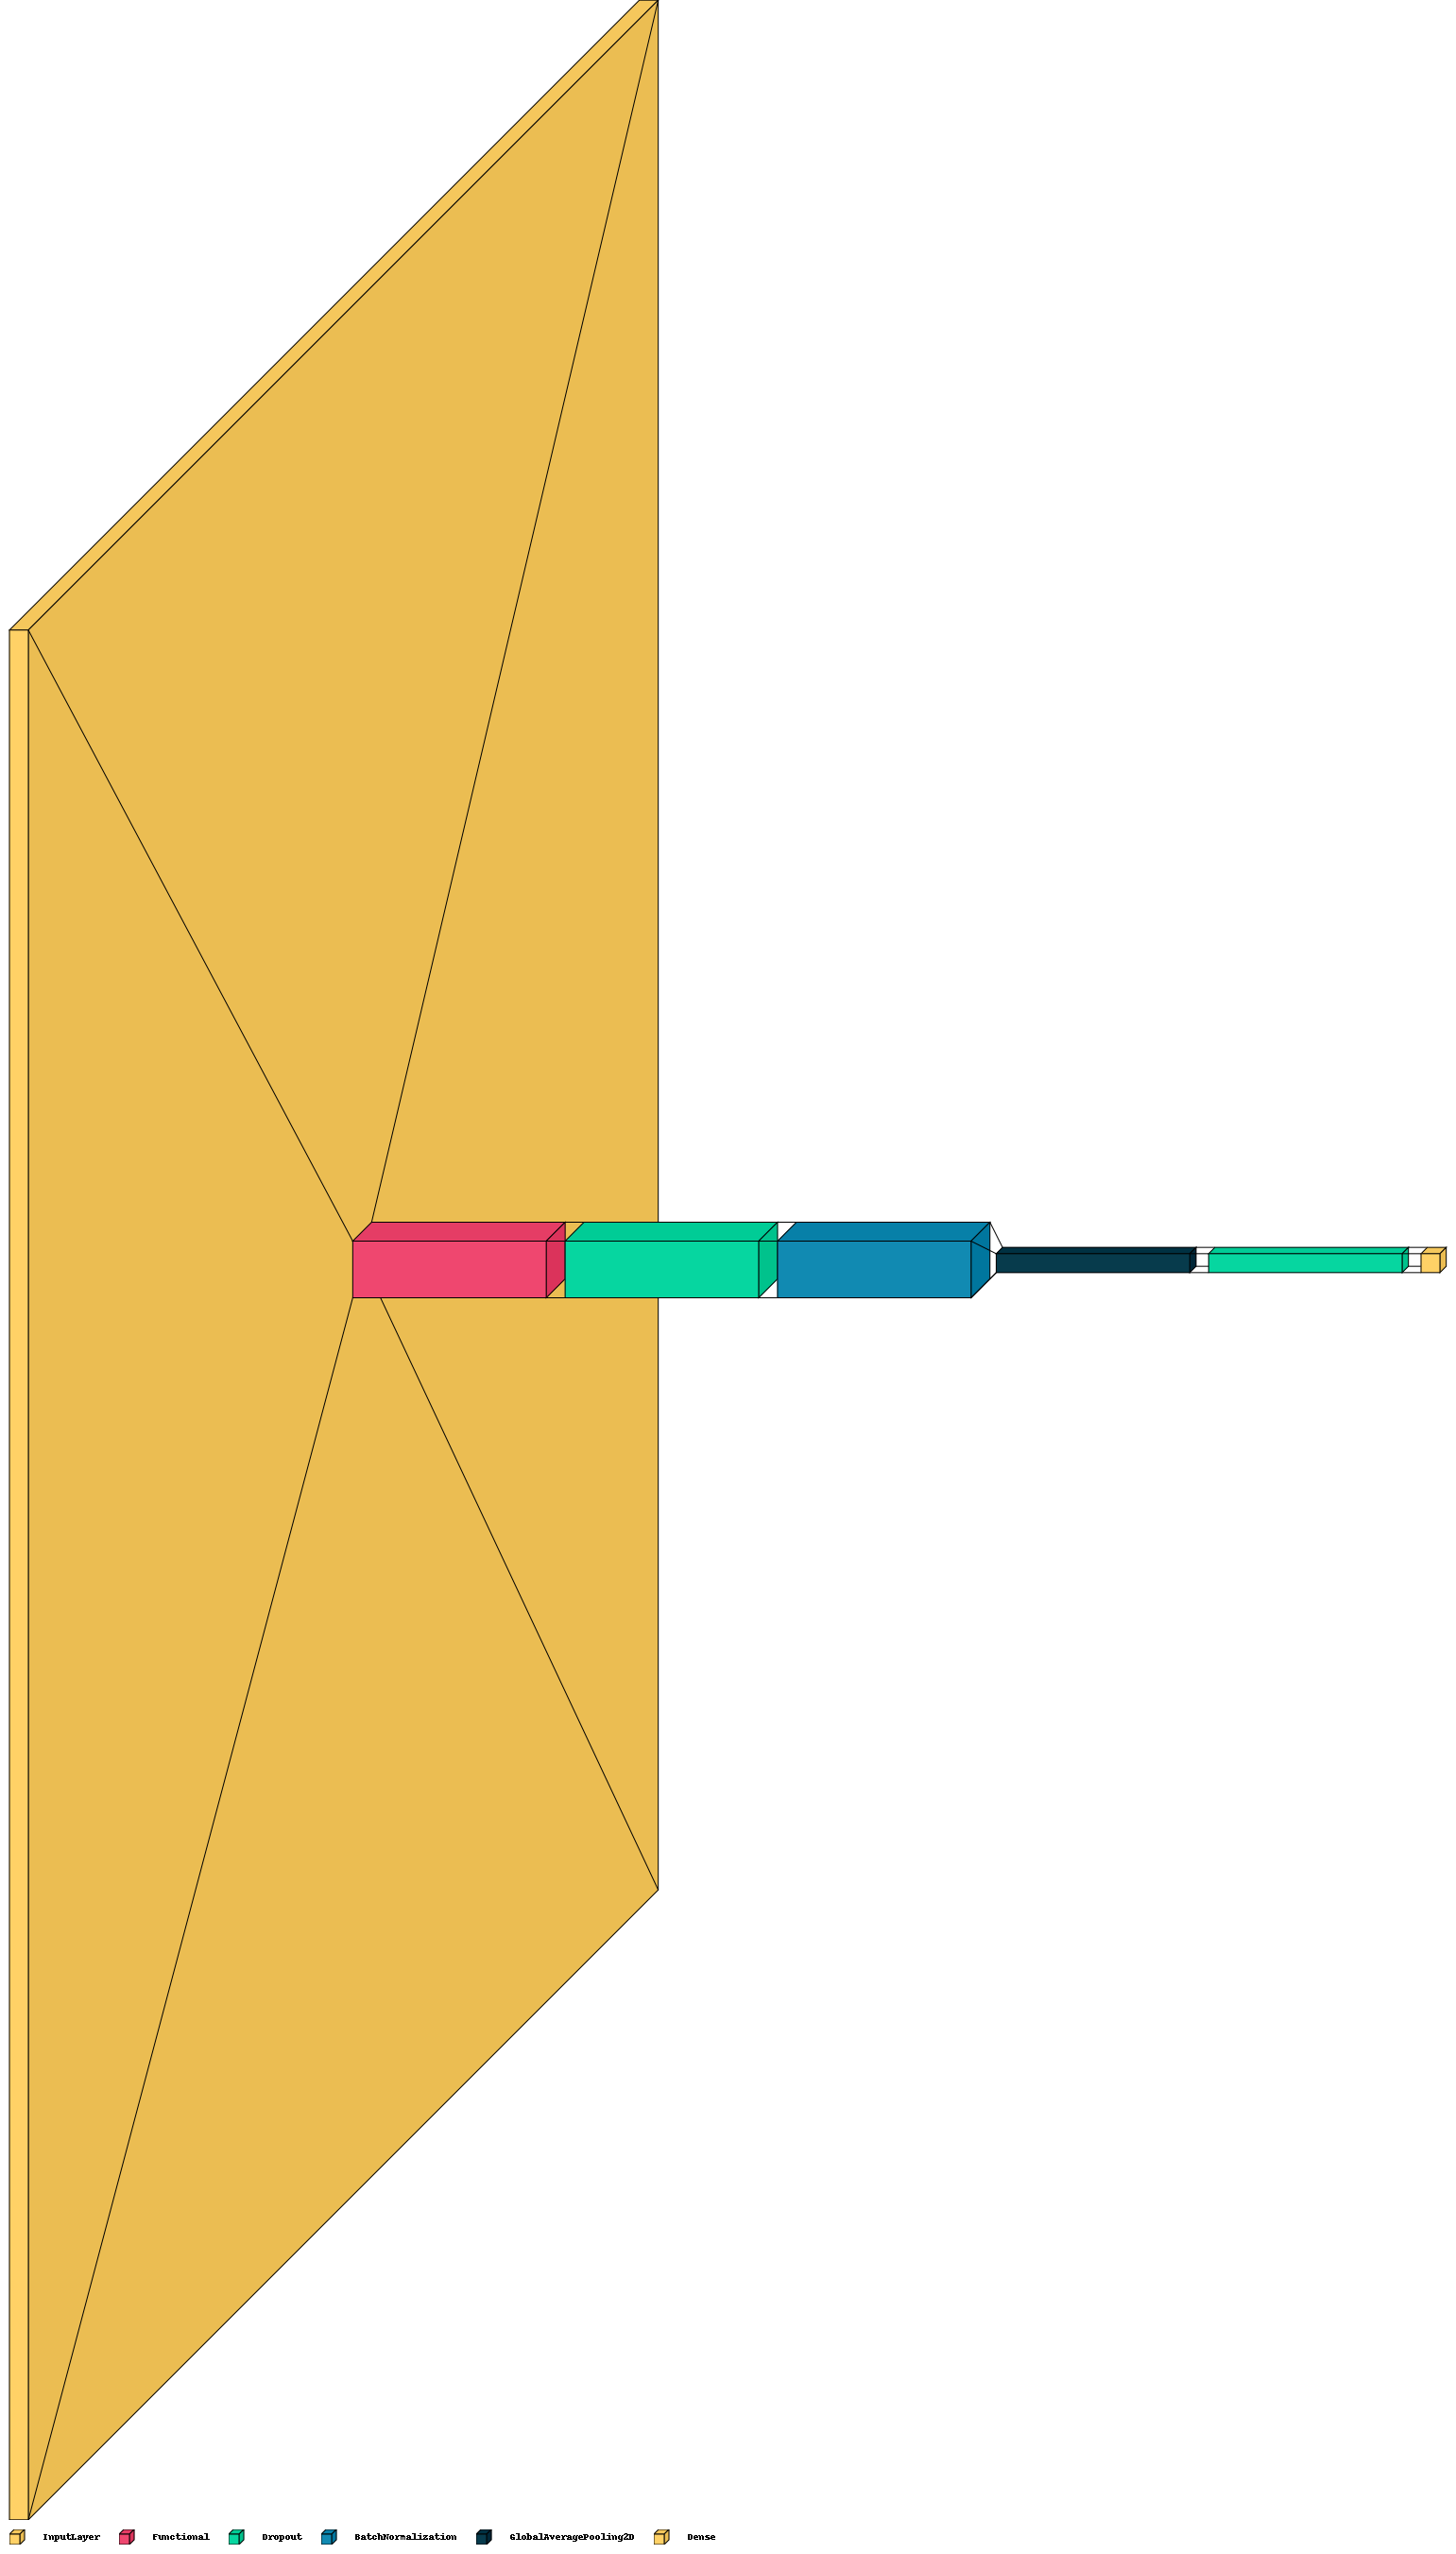

In [ ]:
model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

### c) Train and save the model

In [ ]:
# Create folders and callbacks and fit
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = 'auto', patience=15, restore_best_weights = True)

# Train the model
history = model.fit(
    x = train_gen,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = callbacks,
).history

Epoch 1/200
55/55 [==============================] - 21s 204ms/step - loss: 0.7127 - accuracy: 0.7009 - val_loss: 0.6591 - val_accuracy: 0.7667
Epoch 2/200
55/55 [==============================] - 9s 152ms/step - loss: 0.2133 - accuracy: 0.9292 - val_loss: 0.8832 - val_accuracy: 0.7667
Epoch 3/200
55/55 [==============================] - 9s 164ms/step - loss: 0.0900 - accuracy: 0.9703 - val_loss: 0.8631 - val_accuracy: 0.7333
Epoch 4/200
55/55 [==============================] - 9s 163ms/step - loss: 0.0958 - accuracy: 0.9680 - val_loss: 0.7257 - val_accuracy: 0.7667
Epoch 5/200
55/55 [==============================] - 9s 157ms/step - loss: 0.1446 - accuracy: 0.9521 - val_loss: 0.9401 - val_accuracy: 0.8000
Epoch 6/200
55/55 [==============================] - 9s 157ms/step - loss: 0.0984 - accuracy: 0.9658 - val_loss: 0.6920 - val_accuracy: 0.8000
Epoch 7/200
55/55 [==============================] - 12s 209ms/step - loss: 0.0872 - accuracy: 0.9703 - val_loss: 0.9011 - val_accuracy: 0.73

In [ ]:
# Save best epoch model
str_directory_InceptionV3 = os.path.join('models_experiments','Experiments_' + date_version + '/InceptionV3_' + date_version)
model.save(str_directory_InceptionV3)

### d) Plot

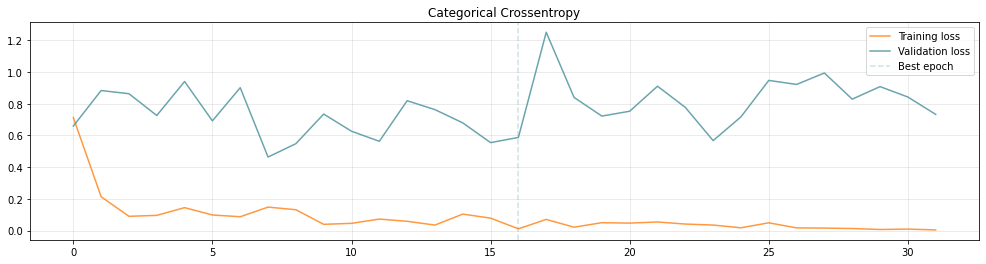

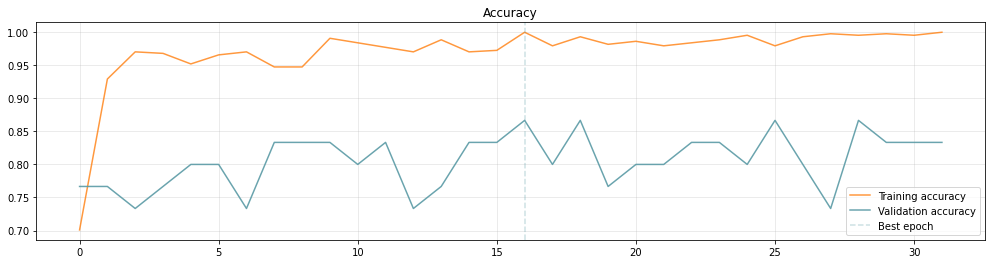

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()


### e) Predictions and confusion matrix

In [ ]:
data =  {
'acc_train': [],
'acc_test': [],
'loss_test': [],
'Accuracy' : [],
'Precision' : [],
'Recall' : [],
'Global F1' : [],
'F1 Normal' : [],
'F1 Pneumonia' : [],
'F1 Tuberculosis' : [],
}

df_results = pd.DataFrame(data)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

results = model.evaluate(test_gen, return_dict=True)

frame_history = pd.DataFrame.from_dict(history)
acc_train = frame_history[['accuracy']].iloc[-1].values

frame_results = pd.DataFrame(data=results, index = model.metrics_names).transpose()
acc_test = frame_results[['accuracy']].values[1]
loss_test = frame_results[['accuracy']].values[0]


# Predict the values from the test set
Y_pred = model.predict_generator(test_gen)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true = test_gen.classes,y_pred = Y_pred_classes)

# Compute the classification metrics
accuracy = accuracy_score(y_true = test_gen.classes,y_pred = Y_pred_classes)
precision = precision_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average='macro')
recall = recall_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average='macro')
f1 = f1_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average='macro')
f1_vector = f1_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average=None)


# Dictionnary with metrics

print('acc_train: ', acc_train)
print('acc_test: ', acc_test)
print('loss_test: ', loss_test)
print('Accuracy', accuracy.round(4))
print('Precision', precision.round(4))
print('Recall', recall.round(4))
print('Global F1', f1.round(4))
print('F1 Normal', f1_vector[0])
print('F1 Pneumonia', f1_vector[1])
print('F1 Tuberculosis', f1_vector[2])


new_row =  {
'acc_train': acc_train,
'acc_test': acc_test,
'loss_test': loss_test,
'Accuracy' : accuracy.round(4),
'Precision' : precision.round(4),
'Recall' : recall.round(4),
'Global F1' : f1.round(4),
'F1 Normal' : f1_vector[0],
'F1 Pneumonia' : f1_vector[1],
'F1 Tuberculosis' : f1_vector[2],
}

df_results = df_results.append(new_row, ignore_index=True)

df_results.to_excel('results_InceptionV3_finetuning.xlsx')
!cp results_InceptionV3_finetuning.xlsx "/content/drive/Shareddrives/Applied AI Project/Pedro/Results" #wherever u want

df_results

4/4 [==============================] - 1s 381ms/step - loss: 0.2852 - accuracy: 0.8846
acc_train:  [1.]
acc_test:  [0.88461536]
loss_test:  [0.28518143]
Accuracy 0.8667
Precision 0.8593
Recall 0.8593
Global F1 0.8593
F1 Normal 0.7777777777777778
F1 Pneumonia 1.0
F1 Tuberculosis 0.8000000000000002


acc_train              acc_test             loss_test  Accuracy  Precision  \
0     [1.0]  [0.8846153616905212]  [0.2851814329624176]    0.8667     0.8593   

   Recall  Global F1  F1 Normal  F1 Pneumonia  F1 Tuberculosis  
0  0.8593     0.8593   0.777778           1.0              0.8

## **5.3. DenseNet121**

### a) Pre-processing DenseNet121

In [ ]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.

labels = ['Normal',   
          'Pneumonia',   
          'Tuberculosis']
          
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator(preprocessing_function=tfk.applications.densenet.preprocess_input)
valid_data_gen = ImageDataGenerator(preprocessing_function=tfk.applications.densenet.preprocess_input)
test_data_gen = ImageDataGenerator(preprocessing_function=tfk.applications.densenet.preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=augmentation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)

valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

test_gen = train_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(256,256),
                                              color_mode='rgb',
                                              classes=labels, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

Found 438 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 26 images belonging to 3 classes.


### b) Build the model

In [ ]:
densenet_121 = tfk.applications.densenet.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)
densenet_121.summary()
tfk.utils.plot_model(densenet_121)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def build_model(input_shape):

    ##INPUT

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    ##DENSENET121 as feature extractor
    x = densenet_121(input_layer)

    #x = tfkl.Flatten(name='Flattening')(x)

    x = tfkl.Dropout(0.4, seed=seed)(x)

    """
    ##MLP
    #The first hidden layer consists of 128 nodes, while the second hidden layer consists of 64 nodes. 
    # Both hidden layers use 40% dropout rate and rectified linear unit (ReLU) activation function

    x = tfkl.Dense(
        128, 
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed))(x)

    x = tfkl.Dropout(0.4, seed=seed)(x)

    x = tfkl.Dense(
        64, 
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed))(x)"""

    ## Global pooling
    x = tfkl.BatchNormalization()(x)

    x = tfkl.GlobalAveragePooling2D()(x)

    x = tfkl.Dropout(0.4, seed=seed)(x)
    
    output_layer = tfkl.Dense(units=3, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(x)


    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    ##Fine-tuning
    #frozen before conv4_block1 layer
    for i, layer in enumerate(model.get_layer('densenet121').layers[:140]):
      layer.trainable=False
    for i, layer in enumerate(model.get_layer('densenet121').layers):
      print(i, layer.name, layer.trainable)

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model

0 input_4 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block5_1_

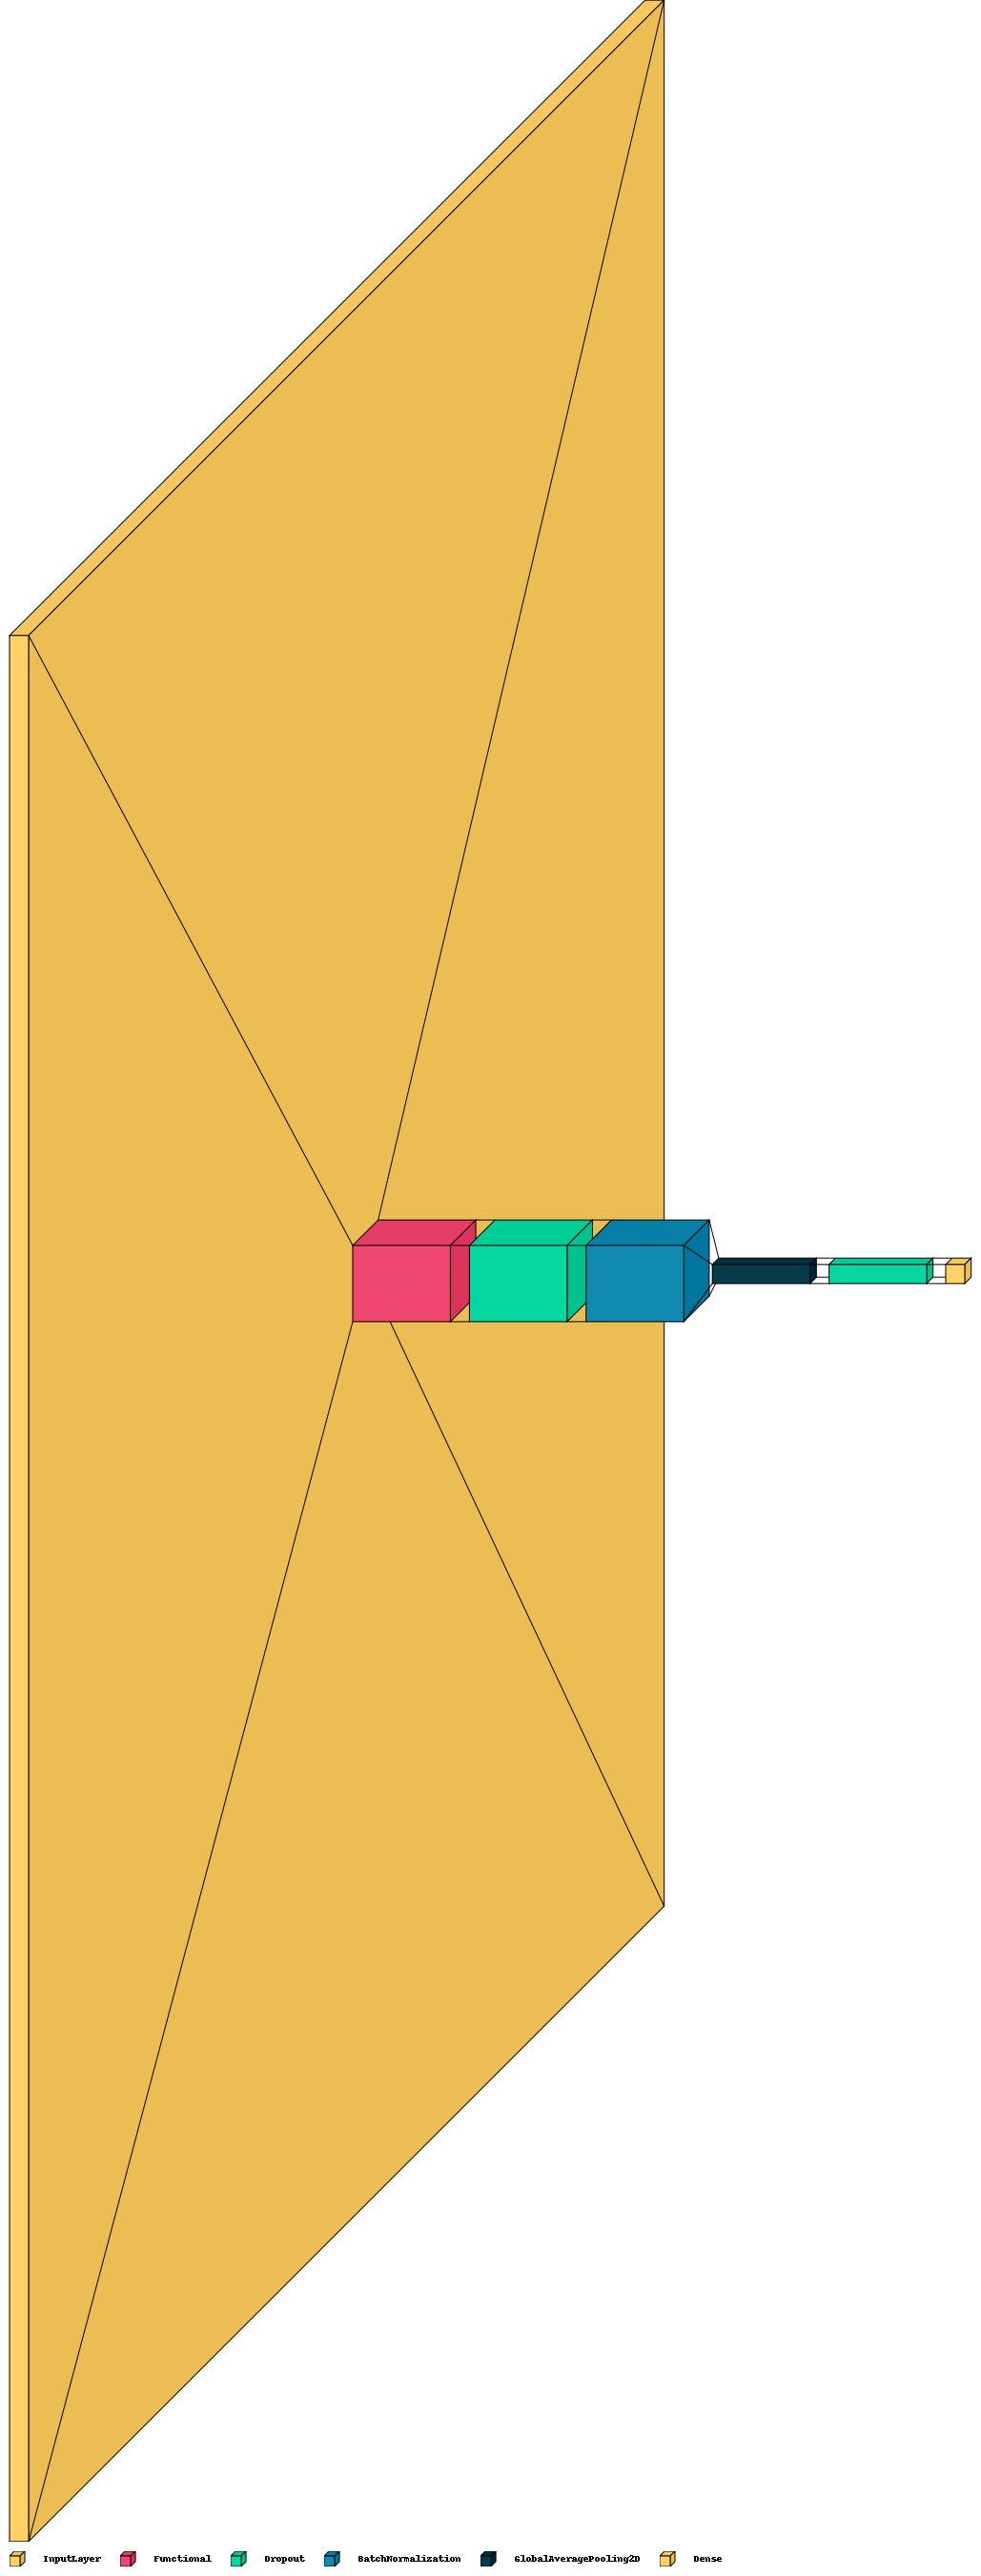

In [ ]:
model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

### c) Train and save the model

In [ ]:
# Create folders and callbacks and fit
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = 'auto', patience=15, restore_best_weights = True)

# Train the model
history = model.fit(
    x = train_gen,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = callbacks,
).history

In [ ]:
# Save best epoch model
str_directory_DenseNet121 = os.path.join('models_experiments','Experiments_' + date_version + '/DenseNet121_' + date_version)
model.save(str_directory_DenseNet121)

### d) Plot

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()


### e) Predictions and confusion matrix

In [ ]:
data =  {
'acc_train': [],
'acc_test': [],
'loss_test': [],
'Accuracy' : [],
'Precision' : [],
'Recall' : [],
'Global F1' : [],
'F1 Normal' : [],
'F1 Pneumonia' : [],
'F1 Tuberculosis' : [],
}

df_results = pd.DataFrame(data)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

results = model.evaluate(test_gen, return_dict=True)

frame_history = pd.DataFrame.from_dict(history)
acc_train = frame_history[['accuracy']].iloc[-1].values

frame_results = pd.DataFrame(data=results, index = model.metrics_names).transpose()
acc_test = frame_results[['accuracy']].values[1]
loss_test = frame_results[['accuracy']].values[0]


# Predict the values from the test set
Y_pred = model.predict_generator(test_gen)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true = test_gen.classes,y_pred = Y_pred_classes)

# Compute the classification metrics
accuracy = accuracy_score(y_true = test_gen.classes,y_pred = Y_pred_classes)
precision = precision_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average='macro')
recall = recall_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average='macro')
f1 = f1_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average='macro')
f1_vector = f1_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average=None)


# Dictionnary with metrics

print('acc_train: ', acc_train)
print('acc_test: ', acc_test)
print('loss_test: ', loss_test)
print('Accuracy', accuracy.round(4))
print('Precision', precision.round(4))
print('Recall', recall.round(4))
print('Global F1', f1.round(4))
print('F1 Normal', f1_vector[0])
print('F1 Pneumonia', f1_vector[1])
print('F1 Tuberculosis', f1_vector[2])


new_row =  {
'acc_train': acc_train,
'acc_test': acc_test,
'loss_test': loss_test,
'Accuracy' : accuracy.round(4),
'Precision' : precision.round(4),
'Recall' : recall.round(4),
'Global F1' : f1.round(4),
'F1 Normal' : f1_vector[0],
'F1 Pneumonia' : f1_vector[1],
'F1 Tuberculosis' : f1_vector[2],
}

df_results = df_results.append(new_row, ignore_index=True)

df_results.to_excel('results_DenseNet.xlsx')
!cp results_DenseNet.xlsx "/content/drive/Shareddrives/Applied AI Project/Pedro/Results" #wherever u want

df_results

## **5.4. EfficientNetB0**

### a) Pre-processing EfficientNetB0

In [ ]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.

labels = ['Normal',   
          'Pneumonia',   
          'Tuberculosis']
          
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator(preprocessing_function=tfk.applications.efficientnet.preprocess_input)
valid_data_gen = ImageDataGenerator(preprocessing_function=tfk.applications.efficientnet.preprocess_input)
test_data_gen = ImageDataGenerator(preprocessing_function=tfk.applications.efficientnet.preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=augmentation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)

valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

test_gen = train_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(256,256),
                                              color_mode='rgb',
                                              classes=labels, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

### b) Build the model

In [ ]:
efficientnet_B0 = tfk.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)
efficientnet_B0.summary()
tfk.utils.plot_model(efficientnet_B0)

In [ ]:
def build_model(input_shape):

    ##INPUT

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    ##DENSENET121 as feature extractor
    x = efficientnet_B0(input_layer)

    #x = tfkl.Flatten(name='Flattening')(x)

    x = tfkl.Dropout(0.4, seed=seed)(x)

    """
    ##MLP
    #The first hidden layer consists of 128 nodes, while the second hidden layer consists of 64 nodes. 
    # Both hidden layers use 40% dropout rate and rectified linear unit (ReLU) activation function

    x = tfkl.Dense(
        128, 
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed))(x)

    x = tfkl.Dropout(0.4, seed=seed)(x)

    x = tfkl.Dense(
        64, 
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed))(x)"""

    ## Global pooling
    x = tfkl.BatchNormalization()(x)

    x = tfkl.GlobalAveragePooling2D()(x)

    x = tfkl.Dropout(0.4, seed=seed)(x)
    
    output_layer = tfkl.Dense(units=3, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(x)


    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    ##Fine-tuning
    #frozen before block4a layer
    for i, layer in enumerate(model.get_layer('efficientnetb0').layers[:76]):
      layer.trainable=False
    for i, layer in enumerate(model.get_layer('efficientnetb0').layers):
      print(i, layer.name, layer.trainable)

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)



### c) Train and save the model

In [ ]:
# Create folders and callbacks and fit
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = 'auto', patience=15, restore_best_weights = True)

# Train the model
history = model.fit(
    x = train_gen,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = callbacks,
).history

In [ ]:
# Save best epoch model
str_directory_EfficientNetB0 = os.path.join('models_experiments','Experiments_' + date_version + '/EfficientNetB0_' + date_version)
model.save(str_directory_EfficientNetB0)

### d) Plot

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()


### e) Predictions and confusion matrix

In [ ]:
data =  {
'acc_train': [],
'acc_test': [],
'loss_test': [],
'Accuracy' : [],
'Precision' : [],
'Recall' : [],
'Global F1' : [],
'F1 Normal' : [],
'F1 Pneumonia' : [],
'F1 Tuberculosis' : [],
}

df_results = pd.DataFrame(data)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

results = model.evaluate(test_gen, return_dict=True)

frame_history = pd.DataFrame.from_dict(history)
acc_train = frame_history[['accuracy']].iloc[-1].values

frame_results = pd.DataFrame(data=results, index = model.metrics_names).transpose()
acc_test = frame_results[['accuracy']].values[1]
loss_test = frame_results[['accuracy']].values[0]


# Predict the values from the test set
Y_pred = model.predict_generator(test_gen)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true = test_gen.classes,y_pred = Y_pred_classes)

# Compute the classification metrics
accuracy = accuracy_score(y_true = test_gen.classes,y_pred = Y_pred_classes)
precision = precision_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average='macro')
recall = recall_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average='macro')
f1 = f1_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average='macro')
f1_vector = f1_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average=None)


# Dictionnary with metrics

print('acc_train: ', acc_train)
print('acc_test: ', acc_test)
print('loss_test: ', loss_test)
print('Accuracy', accuracy.round(4))
print('Precision', precision.round(4))
print('Recall', recall.round(4))
print('Global F1', f1.round(4))
print('F1 Normal', f1_vector[0])
print('F1 Pneumonia', f1_vector[1])
print('F1 Tuberculosis', f1_vector[2])


new_row =  {
'acc_train': acc_train,
'acc_test': acc_test,
'loss_test': loss_test,
'Accuracy' : accuracy.round(4),
'Precision' : precision.round(4),
'Recall' : recall.round(4),
'Global F1' : f1.round(4),
'F1 Normal' : f1_vector[0],
'F1 Pneumonia' : f1_vector[1],
'F1 Tuberculosis' : f1_vector[2],
}

df_results = df_results.append(new_row, ignore_index=True)

df_results.to_excel('results_EfficientNetB0.xlsx')
!cp results_EfficientNetB0.xlsx "/content/drive/Shareddrives/Applied AI Project/Pedro/Results" #wherever u want

df_results

## **5.5. ResNet50**

### a) Pre-processing ResNet50

In [ ]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator


labels = ['Normal',   
          'Pneumonia',   
          'Tuberculosis']

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator(preprocessing_function=tfk.applications.resnet50.preprocess_input)
valid_data_gen = ImageDataGenerator(preprocessing_function=tfk.applications.resnet50.preprocess_input)
test_data_gen = ImageDataGenerator(preprocessing_function=tfk.applications.resnet50.preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256,256), #(256,256)
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8, #default =32
                                               shuffle=True,
                                               seed=seed)

valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

test_gen = train_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(256,256),
                                              color_mode='rgb',
                                              classes=labels, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

### b) Build the model

In [ ]:
# Download and plot the resnet50 model
resnet50 = tfk.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)

In [ ]:
def build_model(input_shape):

    ##INPUT

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    x = resnet50(input_layer)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    
    output_layer = tfkl.Dense(units=3, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(x)


    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    ##Fine-tuning
    #All layers trainable
    for i, layer in enumerate(model.get_layer('resnet50').layers):
      layer.trainable=True
    #for i, layer in enumerate(model.get_layer('resnet50').layers[165:]):
      #layer.trainable = True
    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model

### c) Train and save the model

In [ ]:
# Create folders and callbacks and fit
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = 'auto', patience=15, restore_best_weights = True)

# Train the model
hist = model.fit(
    x = train_gen,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = callbacks,
    batch_size = 32,
    validation_batch_size = 32
).history

In [ ]:
# Save best epoch model
str_directory_ResNet50 = os.path.join('models_experiments','Experiments_' + date_version + '/Resnet50_2artcovid19_modified' + date_version)
model.save(str_directory_ResNet50)

### d) Plot

In [ ]:
best_epoch = np.argmax(hist['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(hist['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(hist['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(hist['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(hist['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()



### e) Predictions and confusion matrix

In [ ]:
data =  {
'acc_train': [],
'acc_test': [],
'loss_test': [],
'Accuracy' : [],
'Precision' : [],
'Recall' : [],
'Global F1' : [],
'F1 Normal' : [],
'F1 Pneumonia' : [],
'F1 Tuberculosis' : [],
}

df_results = pd.DataFrame(data)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

results = model.evaluate(test_gen, return_dict=True)

frame_history = pd.DataFrame.from_dict(hist)
acc_train = frame_history[['accuracy']].iloc[-1].values

frame_results = pd.DataFrame(data=results, index = model.metrics_names).transpose()
acc_test = frame_results[['accuracy']].values[1]
loss_test = frame_results[['accuracy']].values[0]


# Predict the values from the test set
Y_pred = model.predict_generator(test_gen)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true = test_gen.classes,y_pred = Y_pred_classes)

# Compute the classification metrics
accuracy = accuracy_score(y_true = test_gen.classes,y_pred = Y_pred_classes)
precision = precision_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average='macro')
recall = recall_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average='macro')
f1 = f1_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average='macro')
f1_vector = f1_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average=None)


# Dictionnary with metrics

print('acc_train: ', acc_train)
print('acc_test: ', acc_test)
print('loss_test: ', loss_test)
print('Accuracy', accuracy.round(4))
print('Precision', precision.round(4))
print('Recall', recall.round(4))
print('Global F1', f1.round(4))
print('F1 Normal', f1_vector[0])
print('F1 Pneumonia', f1_vector[1])
print('F1 Tuberculosis', f1_vector[2])


new_row =  {
'acc_train': acc_train,
'acc_test': acc_test,
'loss_test': loss_test,
'Accuracy' : accuracy.round(4),
'Precision' : precision.round(4),
'Recall' : recall.round(4),
'Global F1' : f1.round(4),
'F1 Normal' : f1_vector[0],
'F1 Pneumonia' : f1_vector[1],
'F1 Tuberculosis' : f1_vector[2],
}

df_results = df_results.append(new_row, ignore_index=True)

df_results.to_excel('results_resnet50_2artcovid19_modified.xlsx')
!cp results_resnet50_2artcovid19_modified.xlsx "/content/drive/Shareddrives/Applied AI Project/Pedro/Results" #wherever u want

df_results

## **5.6. Ensemble Transfer Learning**

In [ ]:
trained_models = list()

trained_models.append(tfk.models.load_model(str_directory_VGG16))
trained_models.append(tfk.models.load_model(str_directory_InceptionV3))
trained_models.append(tfk.models.load_model(str_directory_DenseNet121))
trained_models.append(tfk.models.load_model(str_directory_EfficientNetB0))
trained_models.append(tfk.models.load_model(str_directory_ResNet50))

### Averaging

In [ ]:
preds = np.empty([len(Y_pred),3,5])

for i in range(5):
  model_temp = trained_models[i]
  pred_temp = model_temp.predict(test_gen)
  preds[:, :, i] = pred_temp

preds_avg = np.mean(preds, axis=2)
preds_avg = (preds_avg > 0.5)*1

In [ ]:
data =  {
'Accuracy' : [],
'Precision' : [],
'Recall' : [],
'Global F1' : [],
'F1 Normal' : [],
'F1 Pneumonia' : [],
'F1 Tuberculosis' : [],
}

df_results = pd.DataFrame(data)

# Predict the values from the validation dataset
Y_pred = preds_avg

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true = test_gen.classes,y_pred = Y_pred_classes)

# Compute the classification metrics
accuracy = accuracy_score(y_true = test_gen.classes,y_pred = Y_pred_classes)
precision = precision_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average='macro')
recall = recall_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average='macro')
f1 = f1_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average='macro')
f1_vector = f1_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average=None)


# Dictionnary with metrics

print('Accuracy', accuracy.round(4))
print('Precision', precision.round(4))
print('Recall', recall.round(4))
print('Global F1', f1.round(4))
print('F1 Normal', f1_vector[0])
print('F1 Pneumonia', f1_vector[1])
print('F1 Tuberculosis', f1_vector[2])


new_row =  {
'Accuracy' : accuracy.round(4),
'Precision' : precision.round(4),
'Recall' : recall.round(4),
'Global F1' : f1.round(4),
'F1 Normal' : f1_vector[0],
'F1 Pneumonia' : f1_vector[1],
'F1 Tuberculosis' : f1_vector[2],
}

df_results = df_results.append(new_row, ignore_index=True)

df_results.to_excel('results_EnsembleAveraging.xlsx')
!cp results_EnsembleAveraging.xlsx "/content/drive/Shareddrives/Applied AI Project/Pedro/Results" #wherever u want

df_results

4/4 [==============================] - 1s 134ms/step - loss: 0.2594 - accuracy: 0.8846
acc_train:  [0.98630136]
acc_test:  [0.88461536]
loss_test:  [0.25940824]
Accuracy 0.9333
Precision 0.9394
Recall 0.9333
Global F1 0.9296
F1 Normal 0.9
F1 Pneumonia 1.0
F1 Tuberculosis 0.888888888888889


acc_train              acc_test              loss_test  \
0  [0.9863013625144958]  [0.8846153616905212]  [0.25940823554992676]   

   Accuracy  Precision  Recall  Global F1  F1 Normal  F1 Pneumonia  \
0    0.9333     0.9394  0.9333     0.9296        0.9           1.0   

   F1 Tuberculosis  
0         0.888889

### Major voting

In [ ]:
for i in range(5):
  model_temp = trained_models[i]
  
  pred_temp = model_temp.predict(validation[0])
  pred_temp = (pred_temp > 0.5)*1
  preds_cv[:, :, i] = pred_temp

preds_avg = np.median(preds_cv, axis=2)

In [ ]:
data =  {
'Accuracy' : [],
'Precision' : [],
'Recall' : [],
'Global F1' : [],
'F1 Normal' : [],
'F1 Pneumonia' : [],
'F1 Tuberculosis' : [],
}

df_results = pd.DataFrame(data)

# Predict the values from the validation dataset
Y_pred = preds_avg

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true = valid_gen.classes,y_pred = Y_pred_classes)

# Compute the classification metrics
accuracy = accuracy_score(y_true = valid_gen.classes,y_pred = Y_pred_classes)
precision = precision_score(y_true = valid_gen.classes,y_pred = Y_pred_classes, average='macro')
recall = recall_score(y_true = valid_gen.classes,y_pred = Y_pred_classes, average='macro')
f1 = f1_score(y_true = valid_gen.classes,y_pred = Y_pred_classes, average='macro')
f1_vector = f1_score(y_true = valid_gen.classes,y_pred = Y_pred_classes, average=None)


# Dictionnary with metrics

print('Accuracy', accuracy.round(4))
print('Precision', precision.round(4))
print('Recall', recall.round(4))
print('Global F1', f1.round(4))
print('F1 Normal', f1_vector[0])
print('F1 Pneumonia', f1_vector[1])
print('F1 Tuberculosis', f1_vector[2])


new_row =  {
'Accuracy' : accuracy.round(4),
'Precision' : precision.round(4),
'Recall' : recall.round(4),
'Global F1' : f1.round(4),
'F1 Normal' : f1_vector[0],
'F1 Pneumonia' : f1_vector[1],
'F1 Tuberculosis' : f1_vector[2],
}

df_results = df_results.append(new_row, ignore_index=True)

df_results.to_excel('results_EnsembleMajorVoting.xlsx')
!cp results_EnsembleMajorVoting.xlsx "/content/drive/Shareddrives/Applied AI Project/Pedro/Results" #wherever u want

df_results

4/4 [==============================] - 1s 134ms/step - loss: 0.2594 - accuracy: 0.8846
acc_train:  [0.98630136]
acc_test:  [0.88461536]
loss_test:  [0.25940824]
Accuracy 0.9333
Precision 0.9394
Recall 0.9333
Global F1 0.9296
F1 Normal 0.9
F1 Pneumonia 1.0
F1 Tuberculosis 0.888888888888889


acc_train              acc_test              loss_test  \
0  [0.9863013625144958]  [0.8846153616905212]  [0.25940823554992676]   

   Accuracy  Precision  Recall  Global F1  F1 Normal  F1 Pneumonia  \
0    0.9333     0.9394  0.9333     0.9296        0.9           1.0   

   F1 Tuberculosis  
0         0.888889

# **6. Train the model - Efficient NetB0**




### a) Prepare data

In [ ]:
# Dataset folders 
%cd /content/drive/Shareddrives/Applied AI Project/Alix
dataset_dir = 'Dataset_130123'
training_dir = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')
augmentation_dir = os.path.join(dataset_dir, 'augmentation')

/content/drive/Shareddrives/Applied AI Project/Alix


In [ ]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.

labels = ['Normal',   
          'Pneumonia',   
          'Tuberculosis']
          
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator(preprocessing_function=tfk.applications.efficientnet.preprocess_input)
valid_data_gen = ImageDataGenerator(preprocessing_function=tfk.applications.efficientnet.preprocess_input)
test_data_gen = ImageDataGenerator(preprocessing_function=tfk.applications.efficientnet.preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=augmentation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)

valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

test_gen = train_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(256,256),
                                              color_mode='rgb',
                                              classes=labels, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

Found 7086 images belonging to 3 classes.
Found 360 images belonging to 3 classes.
Found 360 images belonging to 3 classes.


### b) Build the model

In [ ]:
input_shape = (256, 256, 3)


In [ ]:
# Download and import visualkeras library
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


16705208/16705208 [==============================] - 1s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TF

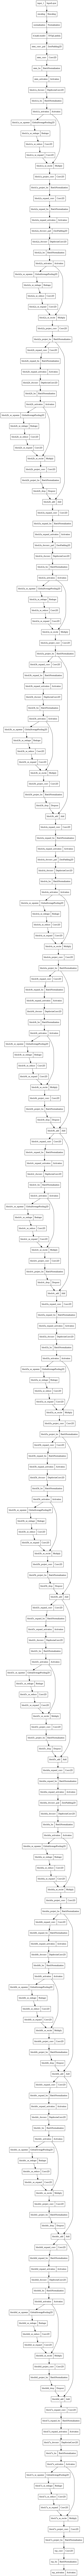

In [ ]:
efficientnet_B0 = tfk.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)
efficientnet_B0.summary()
tfk.utils.plot_model(efficientnet_B0)

In [ ]:
def build_model(input_shape):

    ##INPUT

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    ##DENSENET121 as feature extractor
    x = efficientnet_B0(input_layer)

    #x = tfkl.Flatten(name='Flattening')(x)

    x = tfkl.Dropout(0.4, seed=seed)(x)

    """
    ##MLP
    #The first hidden layer consists of 128 nodes, while the second hidden layer consists of 64 nodes. 
    # Both hidden layers use 40% dropout rate and rectified linear unit (ReLU) activation function

    x = tfkl.Dense(
        128, 
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed))(x)

    x = tfkl.Dropout(0.4, seed=seed)(x)

    x = tfkl.Dense(
        64, 
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed))(x)"""

    ## Global pooling
    x = tfkl.BatchNormalization()(x)

    x = tfkl.GlobalAveragePooling2D()(x)

    x = tfkl.Dropout(0.4, seed=seed)(x)
    
    output_layer = tfkl.Dense(units=3, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(x)


    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    ##Fine-tuning
    #frozen before block4a layer
    for i, layer in enumerate(model.get_layer('efficientnetb0').layers[:76]):
      layer.trainable=False
    for i, layer in enumerate(model.get_layer('efficientnetb0').layers):
      print(i, layer.name, layer.trainable)

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

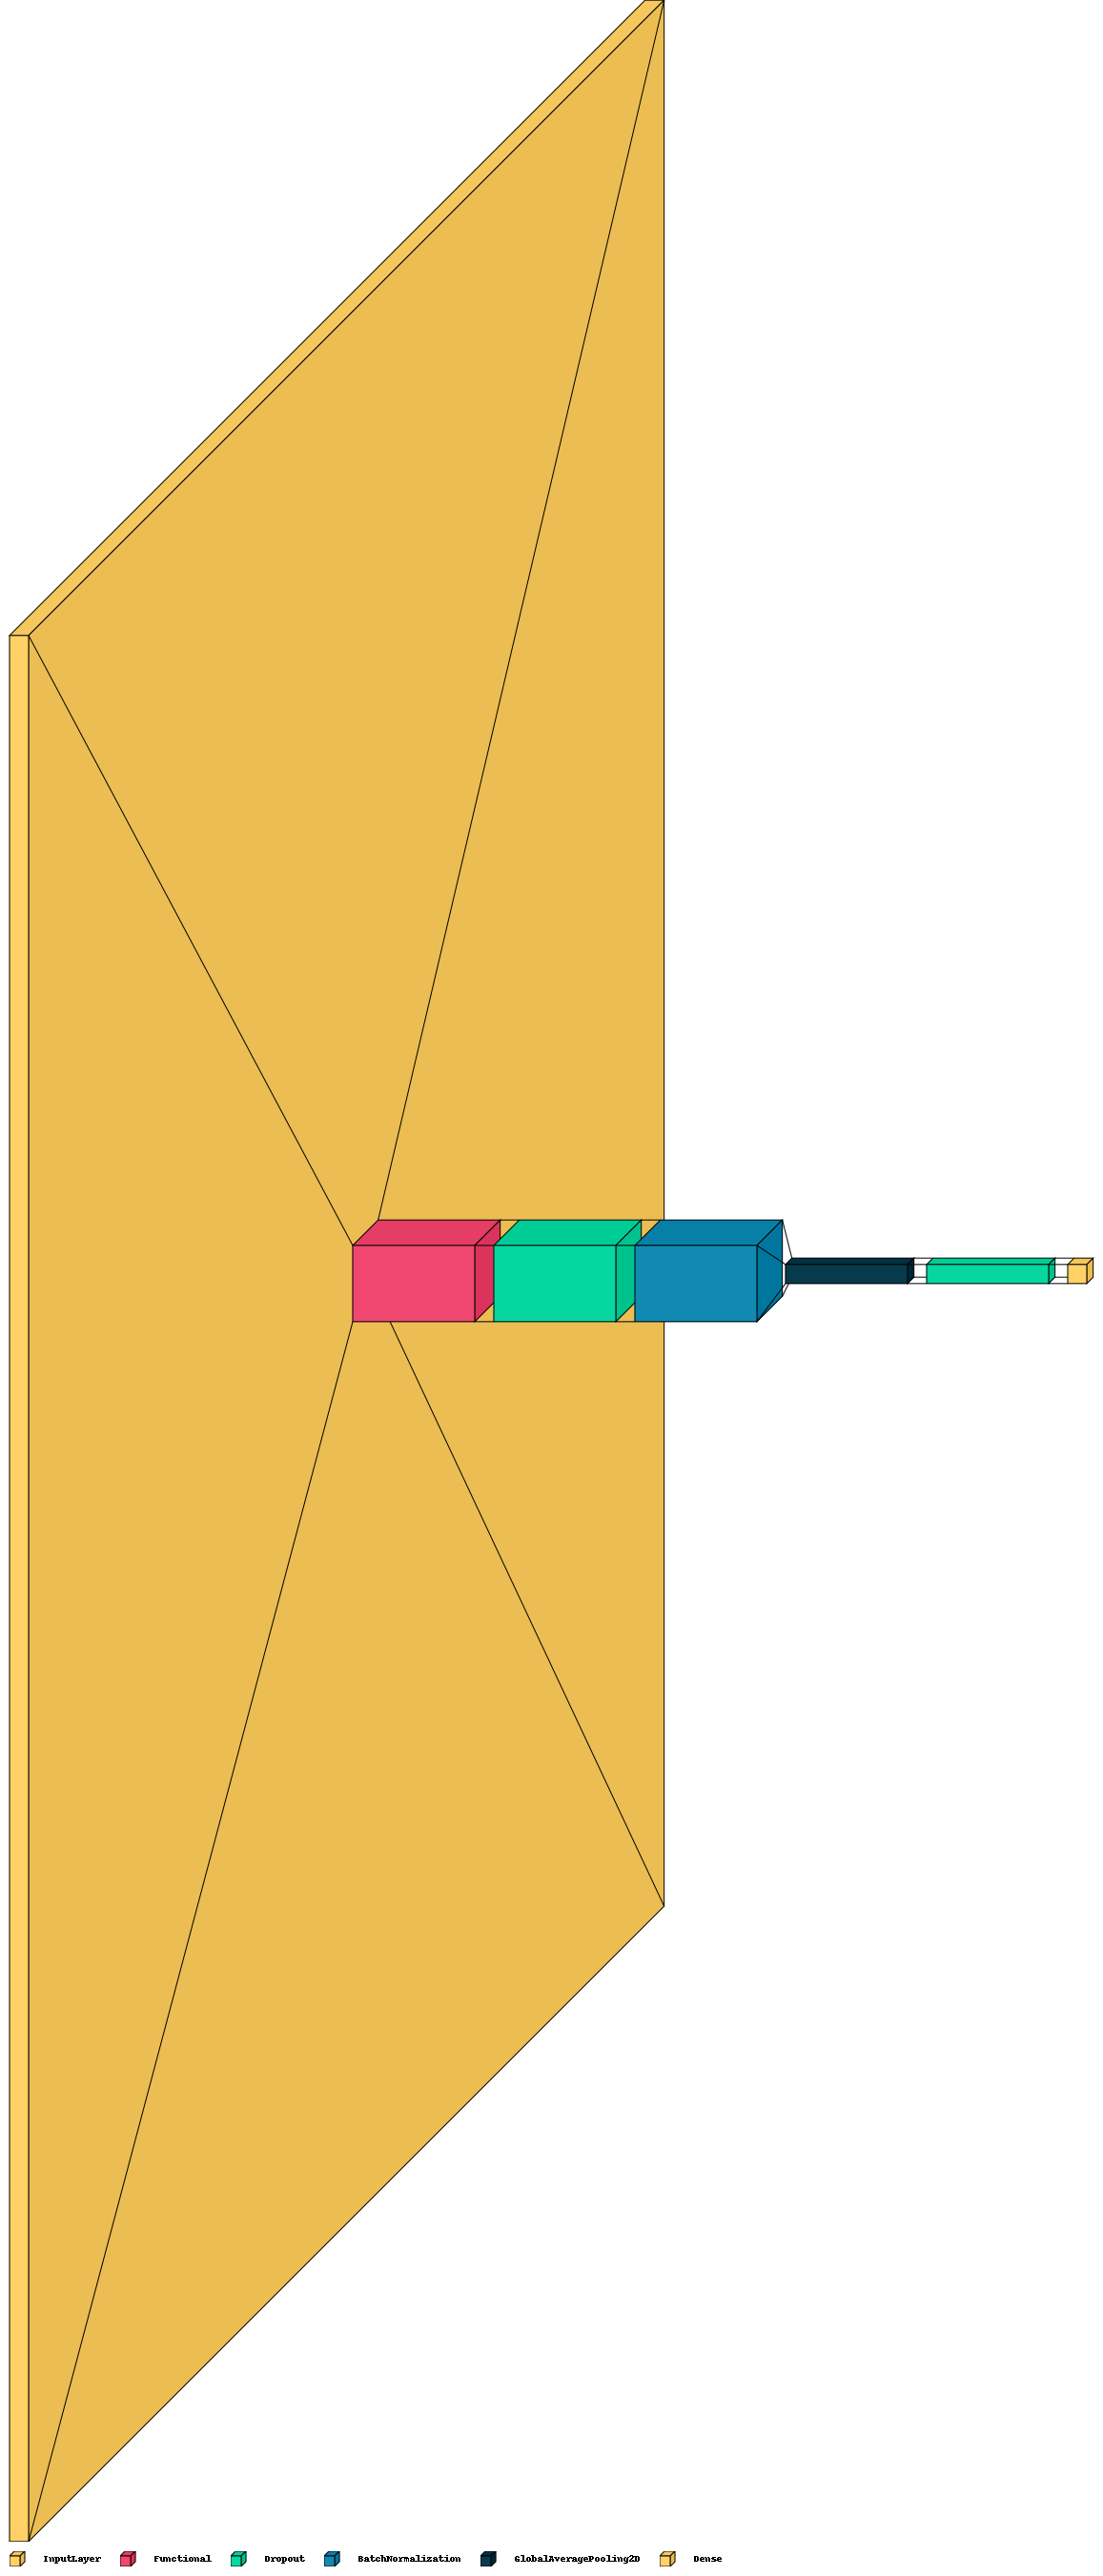

In [ ]:
model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)



### c) Train and save the model

In [ ]:
# Create folders and callbacks and fit
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = 'auto', patience=15, restore_best_weights = True)

# Train the model
history = model.fit(
    x = train_gen,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = callbacks,
).history

Epoch 1/200
886/886 [==============================] - 1867s 2s/step - loss: 0.3945 - accuracy: 0.8450 - val_loss: 0.1768 - val_accuracy: 0.9306
Epoch 2/200
886/886 [==============================] - 170s 192ms/step - loss: 0.1806 - accuracy: 0.9365 - val_loss: 0.1673 - val_accuracy: 0.9250
Epoch 3/200
886/886 [==============================] - 166s 188ms/step - loss: 0.1067 - accuracy: 0.9618 - val_loss: 0.1420 - val_accuracy: 0.9444
Epoch 4/200
886/886 [==============================] - 165s 186ms/step - loss: 0.0849 - accuracy: 0.9739 - val_loss: 0.0940 - val_accuracy: 0.9583
Epoch 5/200
886/886 [==============================] - 164s 185ms/step - loss: 0.0563 - accuracy: 0.9804 - val_loss: 0.1115 - val_accuracy: 0.9639
Epoch 6/200
886/886 [==============================] - 164s 185ms/step - loss: 0.0392 - accuracy: 0.9876 - val_loss: 0.1733 - val_accuracy: 0.9556
Epoch 7/200
886/886 [==============================] - 163s 184ms/step - loss: 0.0330 - accuracy: 0.9907 - val_loss: 0.1

In [ ]:
# Save best epoch model
%cd /content/drive/Shareddrives/Applied AI Project/Pedro
str_directory_EfficientNetB0 = os.path.join('models_experiments','Experiments_' + date_version + '/EfficientNet_Final_dataset130123' + date_version)
model.save(str_directory_EfficientNetB0)

/content/drive/Shareddrives/Applied AI Project/Pedro


### d) Plot

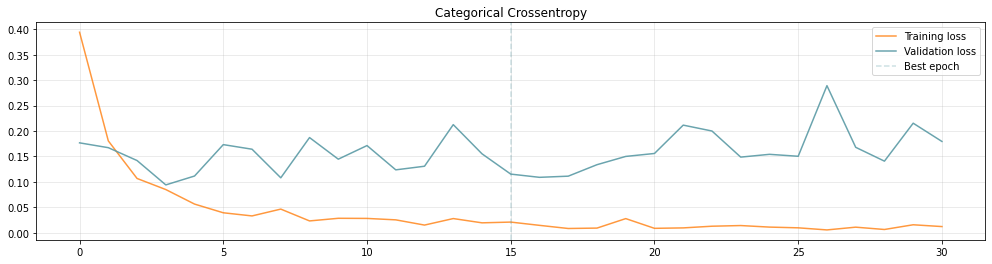

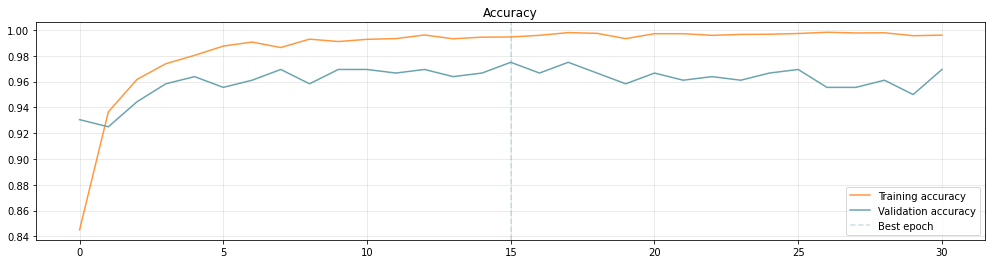

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()


### e) Predictions and confusion matrix

In [ ]:
data =  {
'acc_train': [],
'acc_test': [],
'loss_test': [],
'Accuracy' : [],
'Precision' : [],
'Recall' : [],
'Global F1' : [],
'F1 Normal' : [],
'F1 Pneumonia' : [],
'F1 Tuberculosis' : [],
}

df_results = pd.DataFrame(data)

In [ ]:
%cd /content/drive/Shareddrives/Applied AI Project/Alix

from sklearn.metrics import confusion_matrix, classification_report

results = model.evaluate(test_gen, return_dict=True)

frame_history = pd.DataFrame.from_dict(history)
acc_train = frame_history[['accuracy']].iloc[-1].values

frame_results = pd.DataFrame(data=results, index = model.metrics_names).transpose()
acc_test = frame_results[['accuracy']].values[1]
loss_test = frame_results[['accuracy']].values[0]


# Predict the values from the validation dataset
Y_pred = model.predict_generator(test_gen)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true = test_gen.classes,y_pred = Y_pred_classes)

# Compute the classification metrics
accuracy = accuracy_score(y_true = test_gen.classes,y_pred = Y_pred_classes)
precision = precision_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average='macro')
recall = recall_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average='macro')
f1 = f1_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average='macro')
f1_vector = f1_score(y_true = test_gen.classes,y_pred = Y_pred_classes, average=None)


# Dictionnary with metrics

print('acc_train: ', acc_train)
print('acc_test: ', acc_test)
print('loss_test: ', loss_test)
print('Accuracy', accuracy.round(4))
print('Precision', precision.round(4))
print('Recall', recall.round(4))
print('Global F1', f1.round(4))
print('F1 Normal', f1_vector[0])
print('F1 Pneumonia', f1_vector[1])
print('F1 Tuberculosis', f1_vector[2])


new_row =  {
'acc_train': acc_train,
'acc_test': acc_test,
'loss_test': loss_test,
'Accuracy' : accuracy.round(4),
'Precision' : precision.round(4),
'Recall' : recall.round(4),
'Global F1' : f1.round(4),
'F1 Normal' : f1_vector[0],
'F1 Pneumonia' : f1_vector[1],
'F1 Tuberculosis' : f1_vector[2],
}

df_results = df_results.append(new_row, ignore_index=True)

%cd /content/drive/Shareddrives/Applied AI Project/Pedro
df_results.to_excel('results_EfficientNet_final_dataset130123.xlsx')
!cp results_EfficientNet_final_dataset130123.xlsx "/content/drive/Shareddrives/Applied AI Project/Pedro/Results" #wherever u want

df_results

/content/drive/Shareddrives/Applied AI Project/Alix
45/45 [==============================] - 177s 4s/step - loss: 0.0499 - accuracy: 0.9917
acc_train:  [0.99604857]
acc_test:  [0.99166667]
loss_test:  [0.04991952]
Accuracy 0.9917
Precision 0.9913
Recall 0.9922
Global F1 0.9917
F1 Normal 0.988235294117647
F1 Pneumonia 0.9959514170040485
F1 Tuberculosis 0.9908256880733944
/content/drive/Shareddrives/Applied AI Project/Pedro


acc_train              acc_test              loss_test  \
0  [0.9960485696792603]  [0.9916666746139526]  [0.04991951584815979]   

   Accuracy  Precision  Recall  Global F1  F1 Normal  F1 Pneumonia  \
0    0.9917     0.9913  0.9922     0.9917   0.988235      0.995951   

   F1 Tuberculosis  
0         0.990826

# **7. XAI**

In [ ]:
# Evaluate on test
#model = tfk.models.load_model(str_directory_EfficientNetB0)
%cd /content/drive/Shareddrives/Applied AI Project/Alix

model_test_metrics = model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics with data augmentation")
print(model_test_metrics)


/content/drive/Shareddrives/Applied AI Project/Alix
45/45 [==============================] - 6s 134ms/step - loss: 0.1128 - accuracy: 0.9556

Test metrics with data augmentation
{'loss': 0.11282943934202194, 'accuracy': 0.9555555582046509}


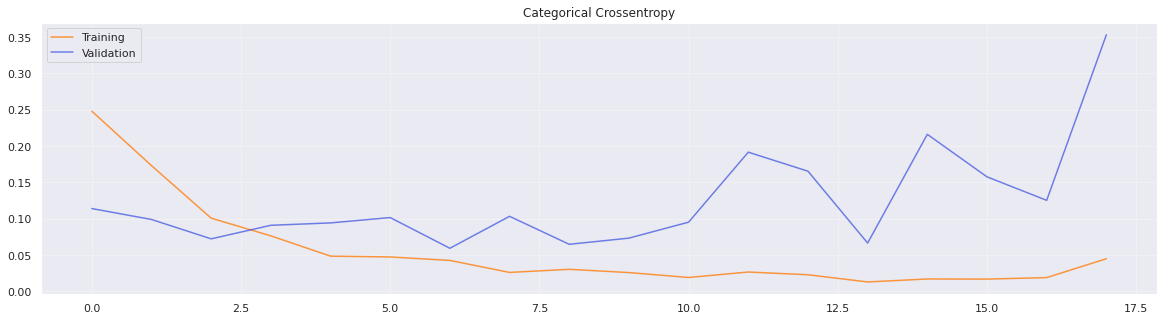

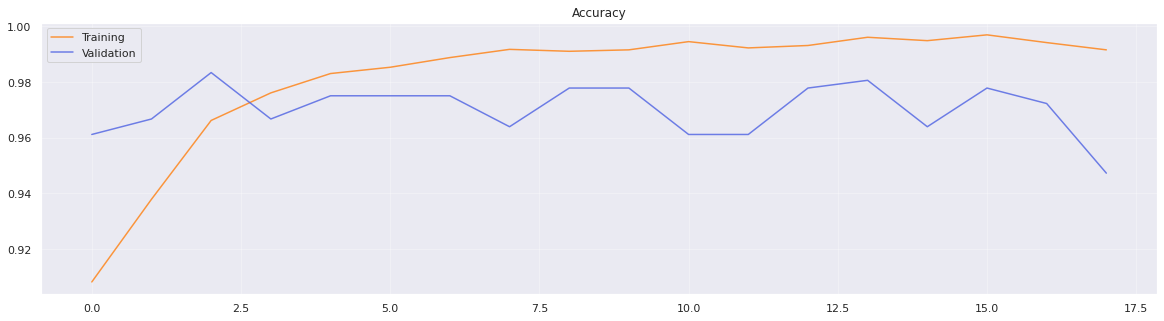

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## 7.2 Confusion matrix

In [ ]:
print(test_gen.classes)
print(Y_pred_classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 2 0 2 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1

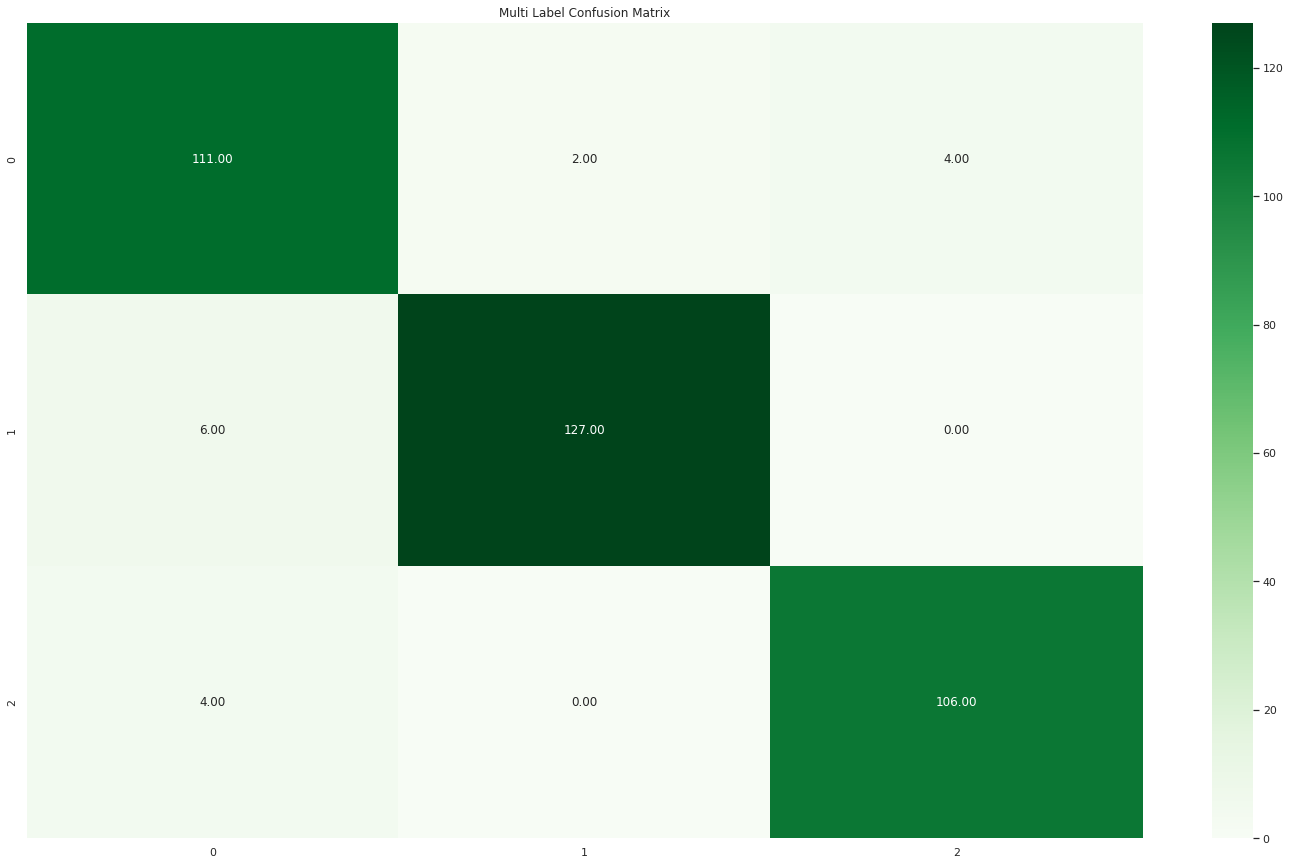

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict the values from the validation dataset
Y_pred = model.predict_generator(test_gen)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true = test_gen.classes,y_pred = Y_pred_classes)

#confusion_mtx.index.name = 'Actual'
#confusion_mtx.columns.name = 'Predicted'

plt.figure(figsize = (25,15))
plt.title("Multi Label Confusion Matrix")

sns.set(font_scale=1.)
sns.heatmap(confusion_mtx, cmap="Greens", annot=True,fmt='.2f')

## 7.3 Classification report

In [ ]:
# Classification report
from sklearn.metrics import classification_report

print(classification_report(
    test_gen.classes,
    Y_pred_classes,
    target_names = sorted(os.listdir(training_dir))))

              precision    recall  f1-score   support

      Normal       0.92      0.95      0.93       117
   Pneumonia       0.98      0.95      0.97       133
Tuberculosis       0.96      0.96      0.96       110

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



## 7.4 Grad-CAM

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def superimposed_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

In [ ]:
#preprocess_input = preprocess_input
#decode_predictions = decode_predictions
#IMG_SIZE = (256, 256)
#last_conv_layer = 'conv2d_14'

In [ ]:
IMG_SIZE = (256, 256)
last_conv_layer_name = "conv2d_4"
model.layers[-1].activation = None
model.layers[-2].activation = None
model.layers[-3].activation = None
model.layers[-4].activation = None

  Img Pneumonia: P03343_2.jpeg ↓ 


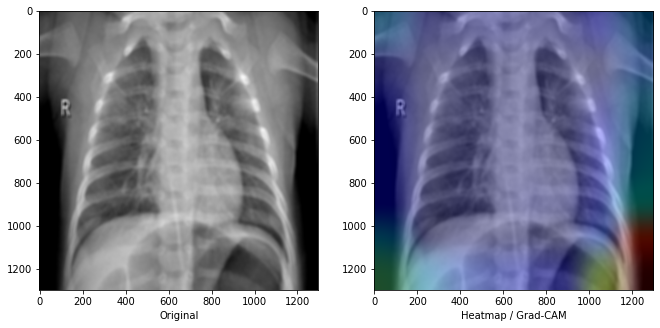

  Img Pneumonia: P08961_1.jpeg ↓ 


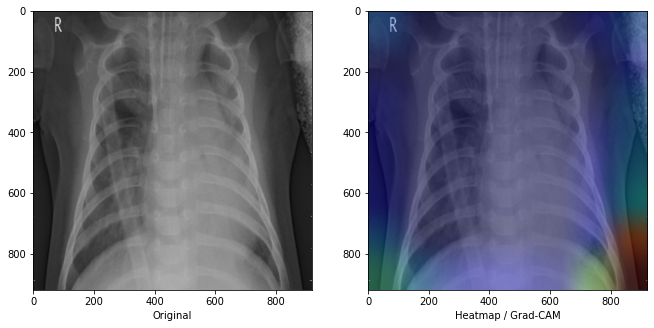

  Img Pneumonia: P04780_2.jpeg ↓ 


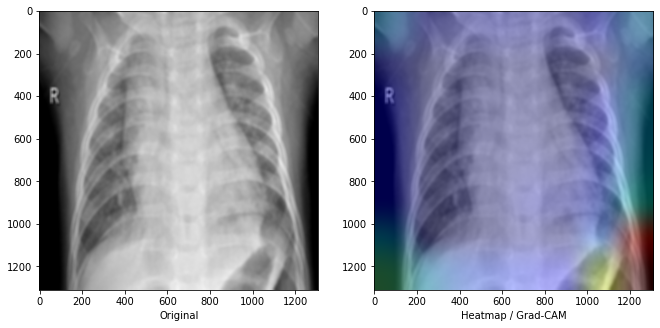

  Img Pneumonia: P02005_2.jpeg ↓ 


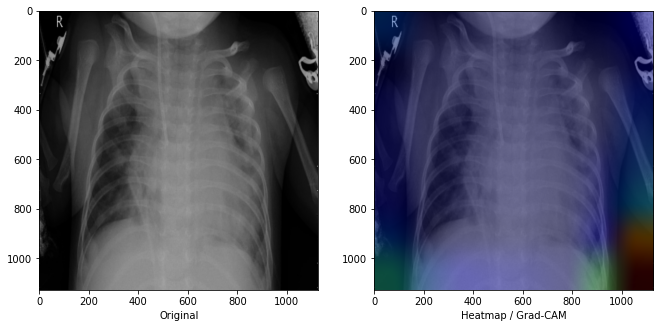

  Img Pneumonia: P06943_2.jpeg ↓ 


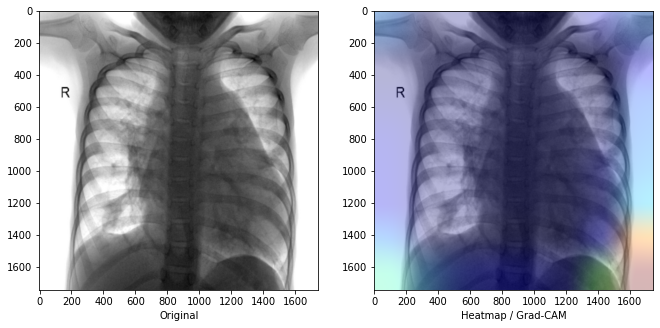

  Img Pneumonia: P10177_2.jpeg ↓ 


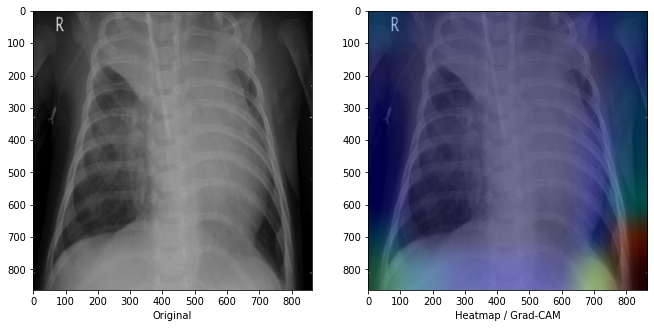

  Img Pneumonia: P07776_1.jpeg ↓ 


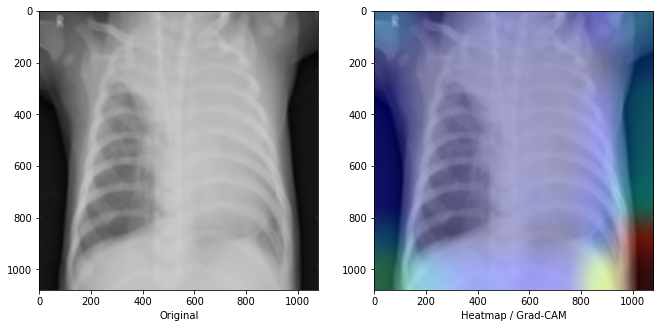

  Img Pneumonia: P04595_1.jpeg ↓ 


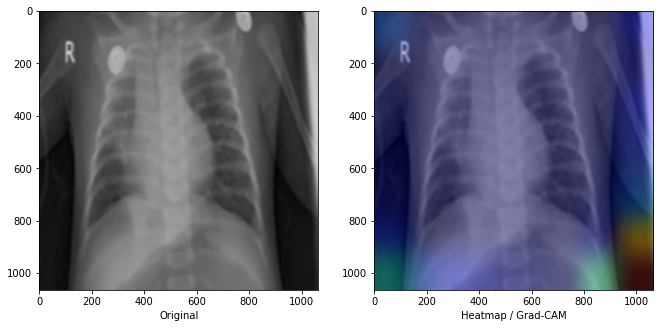

  Img Pneumonia: P08964_1.jpeg ↓ 


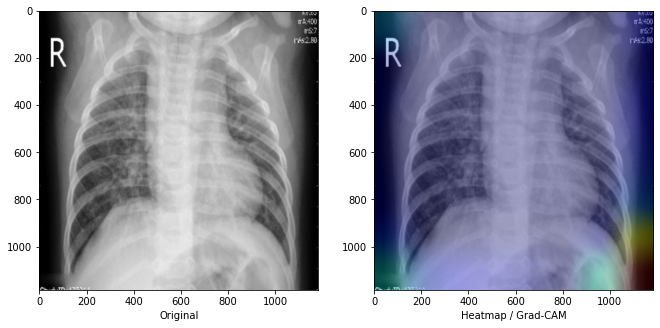

  Img Pneumonia: P09932_1.jpeg ↓ 


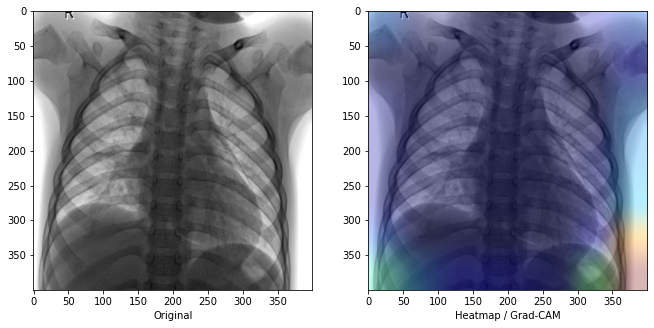

  Img Pneumonia: P02586_2.jpeg ↓ 


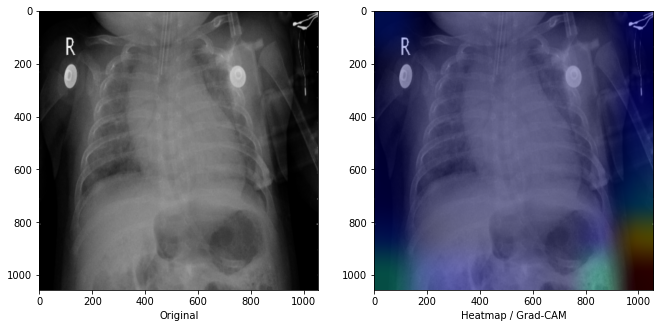

In [ ]:
%matplotlib inline
datasetNameFolder = '/content/drive/Shareddrives/Applied AI Project/Pedro/Dataset_300'
# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8
#test_path = "Dataset_300/test/Pneumonia"
test_path = datasetNameFolder + "/test/Pneumonia"

for files in listdir(test_path):
  
  img_path = os.path.join(test_path,files)
  img_array = preprocess_input(get_img_array(img_path, size=IMG_SIZE))
  img_array_pre = tfk.applications.efficientnet.preprocess_input(img_array)
  # Read images
  #last_layer = model.get_layer('efficientnetb0').get_layer('top_conv')
  #last_layer = model.get_layer('efficientnetb0').layers[-3]
  #grad_model = tf.keras.models.Model(
  #      [model.inputs], [last_layer.output, model.output]
  #  )
  #grad_model = tf.keras.models.Model(
  #      [model.inputs], [model.get_layer('dropout_8').output, model.output]
  #  )
  #['input_layer', 'efficientnetb0', 'dropout', 'batch_normalization', 'global_average_pooling2d', 'dropout_1', 'output_layer'].
  last_layer_name = 'top_conv'
  img_original = mpimg.imread(img_path)
  #heatmap = make_gradcam_heatmap_tf(img_array_pre, grad_model)
  heatmap = make_gradcam_heatmap(img_array_pre, model, last_layer_name)
  img_HM = superimposed_gradcam(img_path, heatmap)

  # display images
  print("\033[92m \033[1m Img Pneumonia: {} ↓ \033[0m".format(files))
  fig, ax = plt.subplots(1,2)
  ax[0].imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
  ax[0].set_xlabel('Original')
  ax[1].imshow(img_HM)
  ax[1].set_xlabel('Heatmap / Grad-CAM')
  
  plt.show()